# Laboratory of Computational Physics mod. B at Phisics of Data, University of Padova

__Authors:__

- Valeria Fioroni (University of Padova)
- Matteo Guida (University of Padova)
- Philipp Zehetner (University of Padova, Ludwig Maximilian University of Munich)

__Supervised by:__

- Professor Marco Zanetti (University of Padova, CERN)
- Professor Stefano Lacaprara (University of Padova, BELLE2)

## 1. The Signal

At the SuperKEKB particle accelerator electrons and positrons collide with a center-of-momentum energy close to the $ \Upsilon (4S) $ resonance. The cross section for the event $ e^+ e^- \rightarrow \Upsilon (4S) $ is 

$$ 
\sigma_{\Upsilon (4S)} = 1.1 \, nb
$$

The $ \Upsilon (4S) $ decays in one of two (almost) equally probable products: 
- $ \Upsilon (4S) \rightarrow B^+ B^- $
- $ \Upsilon (4S) \rightarrow B^0 \bar{B^0} $

For this analysis we are interested in the decay channel
$$
\bar{B^0} / B^0 \rightarrow \eta' \left( \eta \left( \gamma \gamma \right) \pi^+ \pi^- \right) K^0_S \left( \pi^+ \pi^- \right)
$$

The branching fractions are as follows: 

- $ \mathcal{BF} \left( B^0 \rightarrow \eta' K^0 \right) = 6.6 * 10^{-5} $ 
- $ \mathcal{BF} \left( \eta' \rightarrow \eta \pi^+ \pi^- \right) = 0.43 $
- $ \mathcal{BF} \left( \eta \rightarrow \gamma \gamma \right) = 0.40 $
- $ P \left( K^0_S | K^0 \right) = 0.5 $
- $ \mathcal{BF} \left( K^0_S \rightarrow \pi^+ \pi^- \right) = 0.7 $

This leads to a complete branching ratio of 
$ \mathcal{BF} = 3.97 * 10^{-6} $ 

## 2. Our Data

Our Data consists of labelled data, that we used to train and test a _Deep Neural Network_ (DNN) and a _Boosted Decision Tree_ as well as unlabelled data (Data Challenge) in which we are searching for our signal. 

###  Labelled Data

The labelled data consists of various types of background, all corresponding to an integrated luminosity of 
$ \mathcal{L} = 800 \, fb^{-1} $
and signal that was reconstructed from $ 1595000 $ signal events. 

The reconstruction efficiency corresponds to $ \varepsilon = 16.2 \% $


The background types are as follows: 

- $ e^+ e^- \rightarrow u \bar{u} $
- $ e^+ e^- \rightarrow d \bar{d} $
- $ e^+ e^- \rightarrow s \bar{s} $
- $ e^+ e^- \rightarrow c \bar{c} $
- $ e^+ e^- \rightarrow \tau \bar{\tau} $
- $ e^+ e^- \rightarrow B^+ B^- $
- $ e^+ e^- \rightarrow B^0 \bar{B^0} $

We summarize the first five types of backgrounds as _Continuum Background_ and the last two types as _Peaking Background_ and thus build a multi classifier with three types of events. 

Using the complete branching fraction 
$ \mathcal{BF} $
and the cross section 
$ \sigma_{\Upsilon (4S)} $ 
we can calculate to expect to have $N$ events with 
\begin{equation}
N = \mathcal{L} \times \sigma_{\Upsilon(4S)} \times \mathcal{BF} 
= 800 \, fb^{-1} \times 1.1 \, nb \times 3.97 \cdot 10^{-6}
= 3494
\end{equation}
    of which $ \varepsilon \times N = 566 $ should be found by the reconstruction

###  Data Challenge

The Data Challenge is a simulation corresponding to a total luminosity of 
$ \mathcal{L} = 1 \, ab^{-1} $
We can calculate in the same as above, that we should expect a total number of $ N = 4367 $ signal events of which $707$ are reconstructed. 

In [1]:
import os, sys, pprint
import math
import glob
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings("ignore")
from root_pandas import read_root
from random import seed
from random import randint
n_seed=1234
seed(n_seed)

Welcome to JupyROOT 6.16/00


In [2]:
PCA_ON = False
cut_5_sigma = False
VM = False
Local_Matteo = False
Local_Philipp = True
Local_Valeria = False

if Local_Philipp : print("Paths are set to be run on Philipps Computer")
elif VM : print("Paths are set to run on the VM")

Paths are set to be run on Philipps Computer


In [3]:
def memory(df):
    return str((round(df.memory_usage(deep=True).sum() / 1024 ** 2, 2)))+"  Mb"

## 1. Reading and Cleaning Data

The dataset is candidate based so each entry correspond to one candidate. 

In this chapter we:
- import the root files into pandas dataframes  selecting only the features of interest for our analysis
- clean our data sets by removing wrongly reconstructed signal and allowing only one true signal candidate per event.
- apply a $5\sigma$ cut on the mass of the reconstructed $B^0$ on all candidates

In [4]:
Masses = ['B0_M', 'B0_ErrM', 'B0_SigM', 'B0_K_S0_M', 'B0_K_S0_ErrM', 'B0_K_S0_SigM', 'B0_etap_M', 'B0_etap_ErrM', 
          'B0_etap_SigM', 'B0_etap_eta_M', 'B0_etap_eta_ErrM', 'B0_etap_eta_SigM']
Kinetics_CMS = ['B0_Pcms', 'B0_etap_Pcms', 'B0_etap_eta_Pcms', 'B0_etap_eta_gamma0_Pcms', 'B0_etap_eta_gamma1_Pcms',
                'B0_etap_pi0_Pcms', 'B0_etap_pi1_Pcms', 'B0_K_S0_Pcms']
Other_Kinetics = ['B0_deltae', 'B0_mbc']
DecayAngles = ['B0_decayAngle__bo0__bc', 'B0_decayAngle__bo1__bc', 'B0_etap_decayAngle__bo0__bc',
               'B0_etap_decayAngle__bo1__bc', 'B0_etap_decayAngle__bo2__bc']
Positions = ['B0_X', 'B0_ErrX', 'B0_Y', 'B0_ErrY', 'B0_Z', 'B0_ErrZ', 'B0_Rho',  
             'B0_etap_X', 'B0_etap_ErrX', 'B0_etap_Y', 'B0_etap_ErrY', 
             'B0_etap_Z', 'B0_etap_ErrZ', 'B0_etap_Rho',
             'B0_etap_eta_X', 'B0_etap_eta_ErrX', 'B0_etap_eta_Y',
             'B0_etap_eta_ErrY', 'B0_etap_eta_Z', 'B0_etap_eta_ErrZ', 'B0_etap_eta_Rho',
             'B0_etap_pi0_X', 'B0_etap_pi0_ErrX', 'B0_etap_pi0_Y', 'B0_etap_pi0_ErrY', 
             'B0_etap_pi0_Z', 'B0_etap_pi0_ErrZ', 'B0_etap_pi0_Rho', 
             'B0_etap_pi1_X', 'B0_etap_pi1_ErrX', 'B0_etap_pi1_Y', 'B0_etap_pi1_ErrY', 
             'B0_etap_pi1_Z', 'B0_etap_pi1_ErrZ', 'B0_etap_pi1_Rho', 
             'B0_K_S0_X', 'B0_K_S0_ErrX', 'B0_K_S0_Y', 'B0_K_S0_ErrY', 'B0_K_S0_Z',
             'B0_K_S0_ErrZ', 'B0_K_S0_Rho', 
             'B0_cosAngleBetweenMomentumAndVertexVector', 'B0_distance', 'B0_significanceOfDistance',
             'B0_dr', 'B0_etap_pi0_dr', 'B0_etap_pi1_dr', 'B0_K_S0_dr']
Vertex_Training = ['B0_VtxPvalue', 'B0_etap_VtxPvalue', 'B0_etap_eta_VtxPvalue', 'B0_etap_pi0_VtxPvalue',
                   'B0_etap_pi1_VtxPvalue', 'B0_K_S0_VtxPvalue', ]
Continuum_Suppression_Training = ['B0_TrCSMVA']

Training = Kinetics_CMS + Masses + Other_Kinetics + Continuum_Suppression_Training + Positions + DecayAngles + Vertex_Training
Important = Training + ['B0_isSignal', 'evt_no']

if Local_Philipp : 
    path = '/home/philipp/Desktop/Project/DATA/'
    SFiles = glob.glob(os.path.join(path, 'Signal/*.root'))
    CFiles = glob.glob(os.path.join(path, 'Continuous/*.root'))
    PFiles = glob.glob(os.path.join(path, 'Peaking/*.root'))
    DCFiles = glob.glob(os.path.join(path, 'DC/*.root'))
    mpath1 = '/home/philipp/Desktop/Project/Belle-II-analysis/Models/LateNight/Best_Model.h5'
    mpath2 = '/home/philipp/Desktop/Project/Belle-II-analysis/Models/EarlyMorning/Best_Model.h5'
    xgboost_path = '/home/philipp/Desktop/Project/Belle-II-analysis/Models/xgboost_model.dat'
    
if Local_Valeria : 
    path = '/home/utente/Scrivania/Progetto LCP-B/DataBelle2_all/'
    SFiles = glob.glob(os.path.join(path, 'Signal/*.root'))
    CFiles = glob.glob(os.path.join(path, 'Background/Continuum/*.root'))
    PFiles = glob.glob(os.path.join(path, 'Background/Peaking/*.root'))
    DCFiles = glob.glob(os.path.join(path, 'DataChallenge/*.root'))
    mpath1 = '/home/utente/Scrivania/progetto_lcp-b/Models/Final_models/Best_Model.h5'
    mpath2 = '/home/utente/Scrivania/progetto_lcp-b/Models/New_model/Best_Model.h5'
    xgboost_path = '/home/utente/Scrivania/progetto_lcp-b/Models/Final_models/xgboost_model.dat'

if Local_Matteo : 
    path = '/home/guida/Scrivania/PROJECT_2/DataBelle2'
    SFiles = glob.glob(os.path.join(path, 'Signal/*.root'))
    CFiles = glob.glob(os.path.join(path, 'Background/Continuum/*.root'))
    PFiles = glob.glob(os.path.join(path, 'Background/Peaking/*.root'))
    DCFiles = glob.glob(os.path.join(path, 'DataChallenge/*.root'))
    mpath1 = '/home/guida/Scrivania/Final_models/Best_Model.h5'
    mpath2 = '/home/guida/Scrivania/Final_models/Best_Model.h5'
    xgboost_path = '/home/guida/Scrivania/Final_models/xgboost_model.dat'
    
Signal = pd.concat((read_root(f, 'B0', columns=Important) for f in SFiles))
Signal = Signal[Signal['B0_isSignal']==1].reset_index(drop=True)
Continuum_bkg = pd.concat((read_root(f, 'B0', columns=Important) for f in CFiles))
Peaking_bkg = pd.concat((read_root(f, 'B0', columns=Important) for f in PFiles))

#Signal: In case of more than 1 candidate per event select the first one occuring
Mask_duplicated = Signal.duplicated(subset='evt_no', keep='first')
Mask_duplicated=np.logical_not(Mask_duplicated)
Signal=Signal[Mask_duplicated]
Signal.reset_index(drop=True, inplace=True)

Signal=Signal[Training]
Continuum_bkg=Continuum_bkg[Training]
Peaking_bkg=Peaking_bkg[Training]

print("Continuum: {} events".format(Continuum_bkg.shape[0]))
print("Peaking: {} events".format(Peaking_bkg.shape[0]))
print("Signal: {} events \n".format(Signal.shape[0]))
print("Assuming, that originally 1.6M signal events existed, this corresponds to a reconstruction efficiencey of {}%".format(100*Signal.shape[0]/1600000),"\n")

print ("Memory used by Signal : ", memory(Signal))
print ("Memory used by Continuum : ", memory(Continuum_bkg))
print ("Memory used by Peaking  :  ", memory(Peaking_bkg),"\n")

Continuum: 246329 events
Peaking: 2167 events
Signal: 218596 events 

Assuming, that originally 1.6M signal events existed, this corresponds to a reconstruction efficiencey of 13.66225% 

Memory used by Signal :  69.21  Mb
Memory used by Continuum :  79.87  Mb
Memory used by Peaking  :   0.7  Mb 



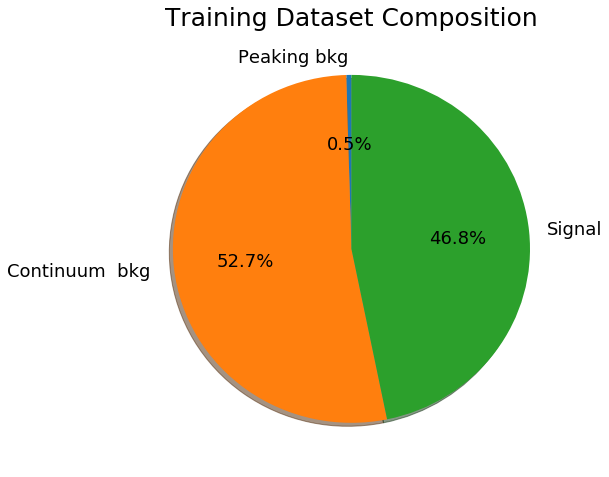

In [5]:
labels = 'Peaking bkg', 'Continuum  bkg ', 'Signal'
sizes = [Peaking_bkg.shape[0],Continuum_bkg.shape[0],Signal.shape[0]]
fig1, ax1 = plt.subplots(1,1, figsize=(8,8))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, textprops={'fontsize': 18})  
ax1.set_title('Training Dataset Composition', fontsize=25)
plt.show()

## 2. Data Preprocessing

In this chapter we:
- label our data.
- turn the label into one-hot vectors as this format is needed by Keras.
- split signal, continuum and peaking separatly into training (50%), valdation (30%) and testing (20%) and then remerge  them together to assure that the balance in the composition of the dataset is preserved.
- combine and shuffle signal, continuum and peaking for training, validation and testing, making sure that the labels are shuffled with the same permutation as the data
- standardize the data (removing mean and scaling the standard deviation to 1)
- perform a Principal Component Analysis (PCA) and use the components necessary for 99% of the variance.

### $5\sigma$ Cut on Reconstructed $B^0$ Mass

The reconstructed mass of the $B^0$ will differ for various reasons: 

- If an event is correctly reconstructed detector inaccuracies of all measured decay particles will add up. The estimated error for each candidate due to this can be found in the branch *B0_ErrM* and is part of our data frame. 
- If the event however is not correctly reconstructed the $B^0$ mass is not necessarily a meaningful quantity an can be far of the desired [PDG](http://pdg.lbl.gov/) value. 

By applying a generous $5\sigma$ cut we already lose a significant amount of background

In [6]:
#Masses from PDG
if cut_5_sigma == True: 
    M_B0 = [5.27955, 0.00026]
    M_K0 = [0.497611, 0.000013]
    M_etap = [0.95778, 0.00006]
    M_eta = [0.547862, 0.000017]

    #Require the B0 mass to be within 5 sigma from PDG value
    Signal = Signal[abs(Signal['B0_M'] - M_B0[0]) < 5 * Signal['B0_ErrM']]
    print("Signal : ",Signal.shape)

    Continuum_bkg = Continuum_bkg[abs(Continuum_bkg['B0_M'] - M_B0[0]) < 5 * Continuum_bkg['B0_ErrM']]
    print("Continuum : ", Continuum_bkg.shape)

    Peaking_bkg = Peaking_bkg[abs(Peaking_bkg['B0_M'] - M_B0[0]) < 5 * Peaking_bkg['B0_ErrM']]
    print("Peaking : ",Peaking_bkg.shape)

####  Comment

The decision not to use the $5\sigma$ cut was determined considering that we want to keep as much peaking background data as possible to train the DNN. The 5 sigma cut reduces the peaking background data of 41%. This is not a good trade-off compared to the 48% reduction in continuum background with this cut.

### Splitting in Training (50%), Validation (30%) and Testing (20%)

In [7]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

n_classes = 3
Signal['Type'] = 2
Continuum_bkg['Type'] = 1
Peaking_bkg['Type'] = 0

# Splitting Data and Label into train, test and validation separatly for each class
X = Signal.drop('Type',axis=1)
Y = Signal['Type']
X_train_S, X_test_val_S, Y_train_S, Y_test_val_S = train_test_split(X, Y, train_size=0.5,random_state=randint(10**6,10**9))
X = X_test_val_S
Y = Y_test_val_S
X_validation_S, X_test_S, Y_validation_S, Y_test_S = train_test_split(X, Y, train_size=0.6,random_state=randint(10**6,10**9))
del(X_test_val_S)
del(Y_test_val_S)
X = Continuum_bkg.drop('Type',axis=1)
Y = Continuum_bkg['Type']
X_train_C, X_test_val_C, Y_train_C, Y_test_val_C = train_test_split(X, Y, train_size=0.5,random_state=randint(10**6,10**9))
X = X_test_val_C
Y = Y_test_val_C
X_validation_C, X_test_C, Y_validation_C, Y_test_C = train_test_split(X, Y, train_size=0.6,random_state=randint(10**6,10**9))
del(X_test_val_C)
del(Y_test_val_C)
X = Peaking_bkg.drop('Type',axis=1)
Y = Peaking_bkg['Type']
X_train_P, X_test_val_P, Y_train_P, Y_test_val_P = train_test_split(X, Y, train_size=0.5,random_state=randint(10**6,10**9))
X = X_test_val_P
Y = Y_test_val_P
X_validation_P, X_test_P, Y_validation_P, Y_test_P = train_test_split(X, Y, train_size=0.6,random_state=randint(10**6,10**9))
del(X_test_val_P)
del(Y_test_val_P)

# Concatenating the different classes, encoding the label as one-hot vectors and shuffling everything
X_Train=np.concatenate((X_train_S, X_train_C, X_train_P), axis=0)
X_Validation=np.concatenate((X_validation_S, X_validation_C, X_validation_P), axis=0)
X_Test=np.concatenate((X_test_S, X_test_C, X_test_P), axis=0)
Y_Train=np.concatenate((Y_train_S, Y_train_C, Y_train_P), axis=0)
Y_Validation=np.concatenate((Y_validation_S, Y_validation_C, Y_validation_P), axis=0)
Y_Test=np.concatenate((Y_test_S, Y_test_C, Y_test_P), axis=0)
Ỳ_Test_not_encoded=Y_Test #used for cut value analysis
Y_Train=to_categorical(Y_Train, num_classes=3)
Y_Validation=to_categorical(Y_Validation, num_classes=3)
Y_Test=to_categorical(Y_Test, num_classes=3)
permutation = np.random.permutation(X_Train.shape[0])
X_Train = X_Train[permutation]
Y_Train = Y_Train[permutation]
permutation = np.random.permutation(X_Validation.shape[0])
X_Validation = X_Validation[permutation]
Y_Validation = Y_Validation[permutation]
permutation = np.random.permutation(X_Test.shape[0])
X_Test = X_Test[permutation]
Y_Test = Y_Test[permutation]

print("X Train shape : ", X_Train.shape)
print("X Validation shape : ",X_Validation.shape)
print("X Test shape : ",X_Test.shape)

Using TensorFlow backend.


X Train shape :  (233545, 83)
X Validation shape :  (140127, 83)
X Test shape :  (93420, 83)


### Feature Scaling

In [8]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_Train = ss.fit_transform(X_Train)
X_Test = ss.transform(X_Test)
X_Validation = ss.transform(X_Validation)

## PCA

Principal component analysis is a method often used to reduce the dimensionality of a data set. Orthogonal transformations are performed on the data set to find the directions with the highest variance. The rotated features (principal components) are sorted in descending variance. The assumption made is, that high variance corresponds to more information and little variance can be neglected as noise.

In our example we require to keep 99% of the total variance and thus can reduce the number of components from 83 to 50

11 variables explain 50% of the variance
36 variables explain 90% of the variance
42 variables explain 95% of the variance
50 variables explain 99% of the variance 

% of dataset reduction with 99 % explained variance : 39.8


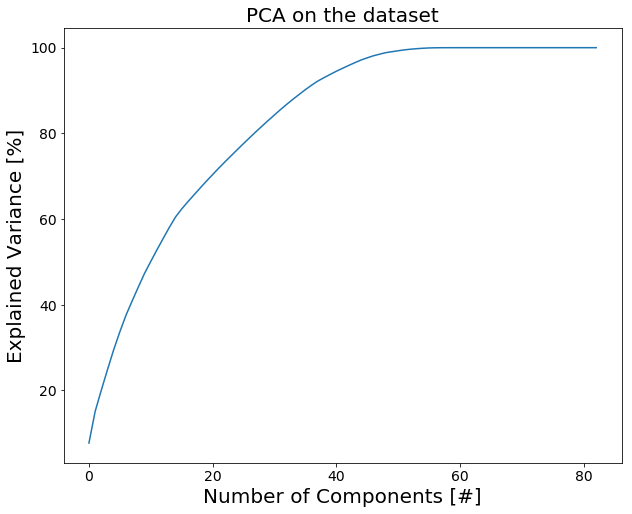

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

pca = PCA(n_components=len(Training))
data = pca.fit_transform(X_Train)
pcTrain = pd.DataFrame(data)
pcTest = pd.DataFrame(data = pca.transform(X_Test))
pcValidation = pd.DataFrame(data = pca.transform(X_Validation))

T50, T90, T95, T99, = False, False, False, False
for i in range(len(pca.explained_variance_ratio_)) : 
    if (sum(pca.explained_variance_ratio_[:i+1]) > 0.5 and T50 ==False) : 
        print(str(i+1) + ' variables explain 50% of the variance')
        T50 = True
        n_50 = i + 1 
    if (sum(pca.explained_variance_ratio_[:i+1]) > 0.9 and T90 ==False) : 
        print(str(i+1) + ' variables explain 90% of the variance')
        T90 = True
        n_90 = i + 1
    if (sum(pca.explained_variance_ratio_[:i+1]) > 0.95 and T95 ==False) : 
        print(str(i+1) + ' variables explain 95% of the variance')
        T95 = True
        n_95 = i + 1
    if (sum(pca.explained_variance_ratio_[:i+1]) > 0.99 and T99 ==False) : 
        print(str(i+1) + ' variables explain 99% of the variance \n')
        T99 = True
        n_99 = i + 1
        
fig = plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_*100))
plt.title('PCA on the dataset',fontsize=20)
plt.xlabel('Number of Components [#]',fontsize=20)
plt.ylabel('Explained Variance [%]',fontsize=20)
plt.tick_params(labelsize=14)
fig.set_size_inches(10, 8)
print('% of dataset reduction with 99 % explained variance :',round((X_Train.shape[1]-n_99)/X_Train.shape[1]*100,1))

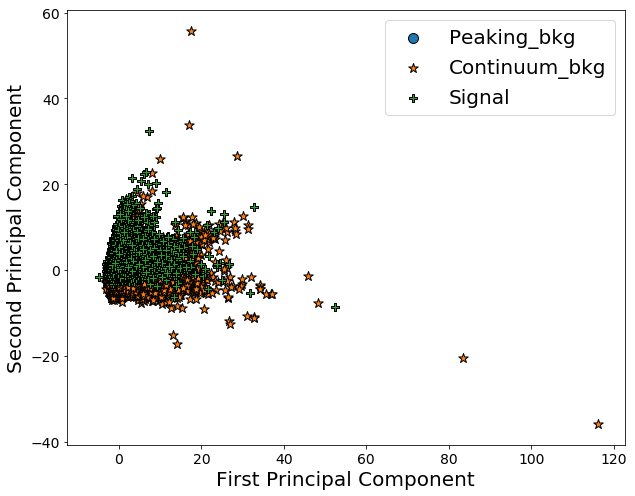

In [10]:
fig = plt.figure()
Y_Train_single_col=np.where(Y_Train==1)[1]
plt.scatter(data[Y_Train_single_col==0,0],data[Y_Train_single_col==0,1], label='Peaking_bkg',edgecolors='black',marker="o",s=100)
plt.scatter(data[Y_Train_single_col==1,0],data[Y_Train_single_col==1,1], label="Continuum_bkg", edgecolors='black', marker="*",s=100)
plt.scatter(data[Y_Train_single_col==2,0],data[Y_Train_single_col==2,1], label='Signal', edgecolors='black', marker="P",s=80)
plt.xlabel('First Principal Component',fontsize=20)
plt.ylabel('Second Principal Component',fontsize=20)
fig.set_size_inches(10, 8)
plt.tick_params(labelsize=14)
plt.legend(fontsize=20)
plt.show()

if not PCA_ON :  
    pcTrain = X_Train
    pcTest = X_Test
    pcValidation = X_Validation

In [11]:
if PCA_ON : 
    pca = PCA(n_components=n_99)
    pcTrain = pca.fit_transform(X_Train)
    pcTest = pd.DataFrame(data = pca.transform(X_Test))
    pcValidation = pd.DataFrame(data = pca.transform(X_Validation))
    print ("Input Dimension has been reduced to ", n_99)
else : 
    input_dim = 83
    print("Input Dimension has not been reduced and no PCA has been performed")

Input Dimension has not been reduced and no PCA has been performed


####  Comment
The decision not to use the PCA was determined considering that the results of the network are worse in that case, leaving all the other parameters unchanged. 
The result that gets worse is the true positive rate in the case of peaking background.

Peaking backgound accounts for 0.46 % of the total dataset. <br>
We believe that PCA embeds the dataset in the space generated by the eigenvectors that maximizes the variance explained for the rest of the dataset, but that penalizes important variables in the distinction of peaking background. <br>
In fact $\sigma \propto \sqrt{N} $ and $N_{pkg} \ll N_{tot} $, $N_{pkg}$ should be very isolated in the phase space so that its characterizing variables are kept in strong consideration. This is not the case with the analyzed dataset.

## 3. The Neural Network

explain what neural network we are using, how we have been training it

In [12]:
from keras.models import load_model
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

Model = load_model(mpath1)
#Model = load_model(mpath2)

Model.summary()
print("\n\n\nEvaluation on Training Set", Model.evaluate(pcTrain, Y_Train))
print("\nEvaluation on Test Set", Model.evaluate(pcTest, Y_Test))
#print(2*'\n')
#print(Model.summary())
#print(Model.evaluate(pcTest, Y_Test))

W0725 13:08:20.958184 140096873670464 deprecation_wrapper.py:119] From /home/philipp/anaconda3/envs/Belle/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0725 13:08:20.975130 140096873670464 deprecation_wrapper.py:119] From /home/philipp/anaconda3/envs/Belle/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0725 13:08:20.975768 140096873670464 deprecation_wrapper.py:119] From /home/philipp/anaconda3/envs/Belle/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0725 13:08:20.982828 140096873670464 deprecation.py:506] From /home/philipp/anaconda3/envs/Belle/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropou

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_93 (Dropout)         (None, 83)                0         
_________________________________________________________________
dense_460 (Dense)            (None, 30)                2520      
_________________________________________________________________
dense_461 (Dense)            (None, 70)                2170      
_________________________________________________________________
dense_462 (Dense)            (None, 30)                2130      
_________________________________________________________________
dense_463 (Dense)            (None, 3)                 93        
Total params: 6,913
Trainable params: 6,913
Non-trainable params: 0
_________________________________________________________________
233545/233545 [==============================] - 3s 12us/step



Evaluation on Training Set [0.061605680450743966, 0.9820762593932647]
93420

OMP: Info #212: KMP_AFFINITY: decoding x2APIC ids.
OMP: Info #210: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-3
OMP: Info #156: KMP_AFFINITY: 4 available OS procs
OMP: Info #157: KMP_AFFINITY: Uniform topology
OMP: Info #179: KMP_AFFINITY: 1 packages x 2 cores/pkg x 2 threads/core (2 total cores)
OMP: Info #214: KMP_AFFINITY: OS proc to physical thread map:
OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to package 0 core 0 thread 0 
OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to package 0 core 0 thread 1 
OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to package 0 core 1 thread 0 
OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to package 0 core 1 thread 1 
OMP: Info #250: KMP_AFFINITY: pid 5769 tid 5769 thread 0 bound to OS proc set 0
OMP: Info #250: KMP_AFFINITY: pid 5769 tid 5849 thread 1 bound to OS proc set 1
OMP: Info #250: KMP_AFFINITY: pid 5769 tid 5851 thread 2 bound to OS proc set 2
OMP: Info #250: 

In [13]:
def plot_confusion_matrix(cm, classes,
                          title1='Confusion matrix \n with normalization',
                          title2='Confusion matrix \n without normalization',
                          cmap=plt.cm.YlOrRd):

    cm0 = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalized 
    cm1 = cm # unnormalized
    fmt0 = '.2f' 
    fmt1 = 'd'
    
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(20, 8)
    im1=ax1.imshow(cm0, interpolation='nearest', cmap=cmap)
    ax1.set_title(title1,fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    ax1.set_xticks(tick_marks)
    ax1.set_xticklabels(dict(zip(classes,tick_marks)), rotation=30,fontsize=15)
    ax1.set_yticks(tick_marks)
    ax1.set_yticklabels(dict(zip(classes,tick_marks)),fontsize=15)
    fig.colorbar(im1, ax=ax1)
    
    thresh = cm0.max() / 2.
    for i, j in itertools.product(range(cm0.shape[0]), range(cm0.shape[1])):
        ax1.text(j, i, format(cm0[i, j], fmt0),
                 horizontalalignment="center",
                 color="black" if cm0[i, j] > thresh else "black",fontsize=15)

    ax1.set_ylabel('TRUE LABEL',fontsize=20)
    ax1.set_xlabel('PREDICTED LABEL',fontsize=20)

    im2=ax2.imshow(cm1, interpolation='nearest', cmap=cmap)
    ax2.set_title(title2,fontsize=25)

    ax2.set_xticks(tick_marks)
    ax2.set_xticklabels(dict(zip(classes,tick_marks)), rotation=30,fontsize=15)
    ax2.set_yticks(tick_marks)
    ax2.set_yticklabels(dict(zip(classes,tick_marks)),fontsize=15)
    
    thresh = cm1.max() / 2.
    for i, j in itertools.product(range(cm1.shape[0]), range(cm1.shape[1])):
        ax2.text(j, i, format(cm1[i, j], fmt1),
                 horizontalalignment="center",
                 color="black" if cm1[i, j] > thresh else "black",fontsize=15)

    ax2.set_ylabel('TRUE LABEL',fontsize=20)
    ax2.set_xlabel('PREDICTED LABEL',fontsize=20)
    fig.colorbar(im2, ax=ax2)
    plt.tight_layout()
    plt.show()

In [14]:
y_score = Model.predict(pcTest)

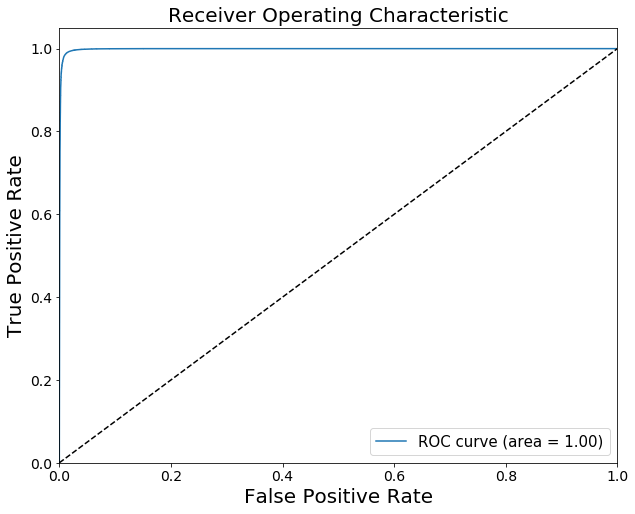

In [15]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(Y_Test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
fig = plt.figure()
plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.title('Receiver Operating Characteristic',fontsize=20)
plt.tick_params(labelsize=14)
plt.legend(loc="lower right",fontsize=15)
fig.set_size_inches(10, 8)
plt.show()

In [16]:
from sklearn.metrics import confusion_matrix
import itertools

# On training set
Y_train_predict =  Model.predict_proba(X_Train)
Y_train_single_col = np.where(Y_Train==1)[1]
Y_train_mo = pd.get_dummies(Y_train_single_col[:])
Y_train_predict_mo = Y_train_predict.round()

In [17]:
cnf_matrix_train = confusion_matrix(Y_train_mo.values.argmax(axis=1), Y_train_predict_mo.argmax(axis=1))

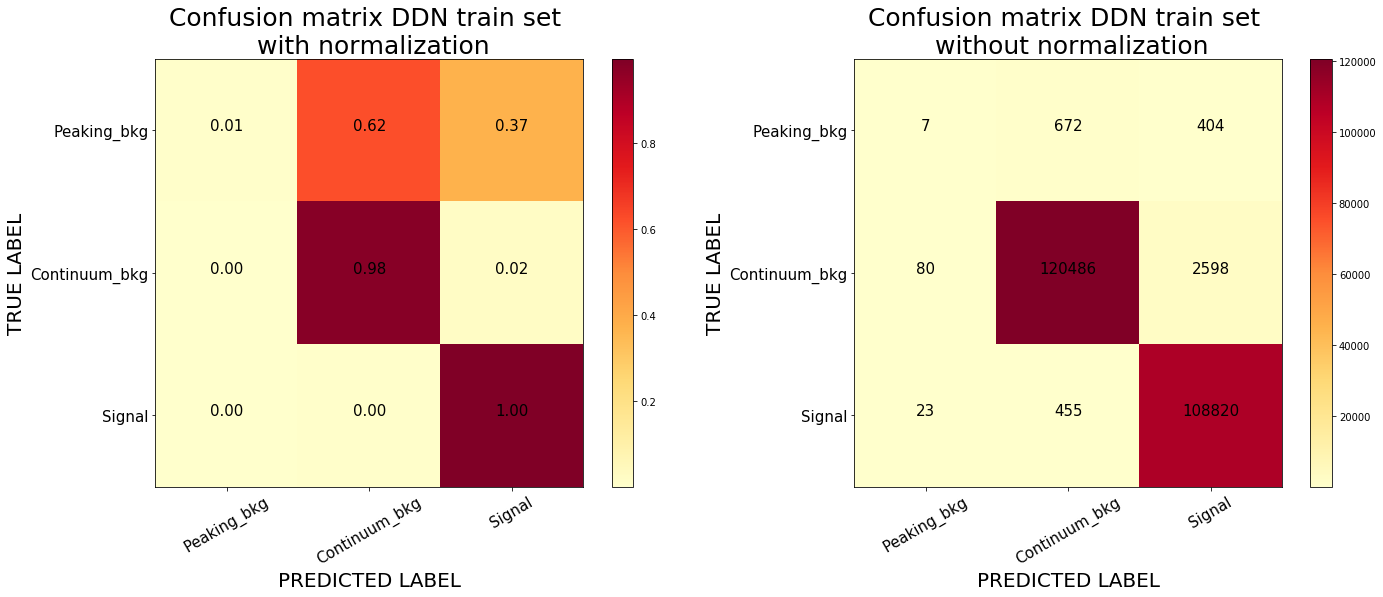

In [18]:
plot_confusion_matrix(cnf_matrix_train, classes=['Peaking_bkg', 'Continuum_bkg',"Signal"],
                      title1='Confusion matrix DDN train set \n with normalization',title2='Confusion matrix DDN train set \n without normalization')

In [19]:
# On test set
Y_test_predict = Model.predict_proba(X_Test)
Y_test_single_col = np.where(Y_Test==1)[1]
Y_test_mo = pd.get_dummies(Y_test_single_col[:])
Y_test_predict_mo = Y_test_predict.round()
cnf_matrix_test = confusion_matrix(Y_test_mo.values.argmax(axis=1), Y_test_predict_mo.argmax(axis=1))

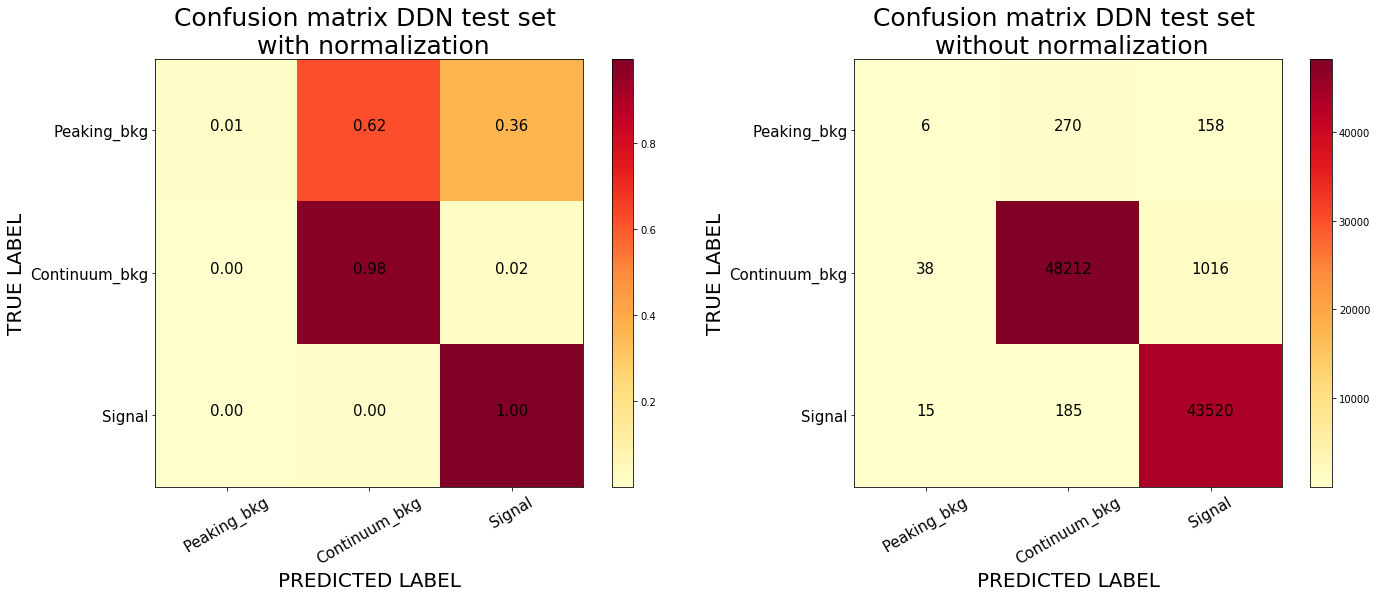

In [20]:
plot_confusion_matrix(cnf_matrix_test, classes=['Peaking_bkg', 'Continuum_bkg',"Signal"],
                      title1='Confusion matrix DDN test set \n with normalization',title2='Confusion matrix DDN test set \n without normalization')

## 4. XGBOOST

To achieve the task of the classification we have tried to look at the results of the Xgboost algorithm. <br>
In fact, besides being one of the best performing algorithms to perform this type of task, [here](https://github.com/dmlc/xgboost/tree/master/demo) you can see, not only great tutorials, but also that the algorithm won several high energy physics ML competitions. <br><br>
The basic idea of the algorithm is to construct ensembles of decision trees. It work iteratively and at each step, we compute the gradient of the cost function w.r.t.the predicted value of the ensemble and add trees that move us in the direction of the gradient.

In [21]:
import xgboost as xgb
xgb_model = joblib.load(xgboost_path)

columnsNamesArr = X_train_S.columns.values
X_Train = pd.DataFrame(X_Train, columns = columnsNamesArr)
X_Validation = pd.DataFrame(X_Validation, columns = columnsNamesArr)
y_pred_train= xgb_model.predict(X_Train)
y_pred_val= xgb_model.predict(X_Validation)

In [22]:
Y_Train_single_col=np.where(Y_Train==1)[1]
Y_Validation_single_col=np.where(Y_Validation==1)[1]
Y_Test_single_col=np.where(Y_Test==1)[1]

y_pred_train = xgb_model.predict(X_Train) 
y_pred_val= xgb_model.predict(X_Validation)

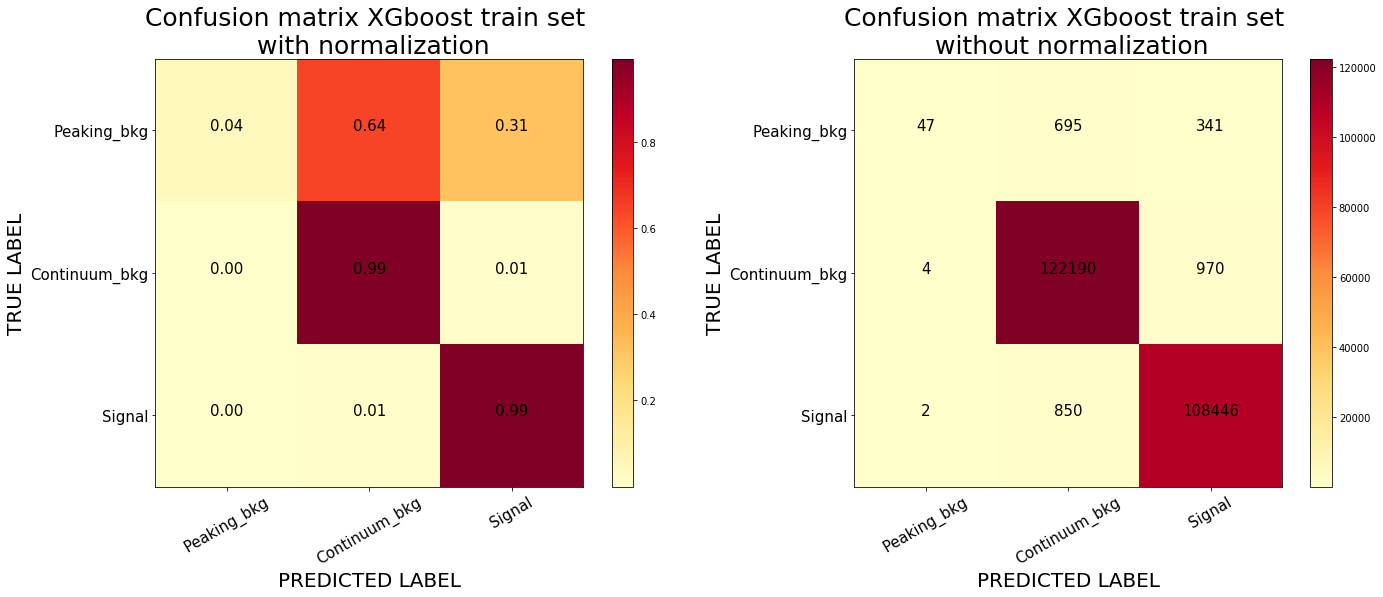

In [23]:
cnf_matrix_xg_train = confusion_matrix(Y_Train_single_col,y_pred_train)
cnf_matrix_xg_train

import itertools
plot_confusion_matrix(cnf_matrix_xg_train, classes=['Peaking_bkg', 'Continuum_bkg',"Signal"],
                      title1="Confusion matrix XGboost train set \n with normalization",
                      title2='Confusion matrix XGboost train set \n without normalization')

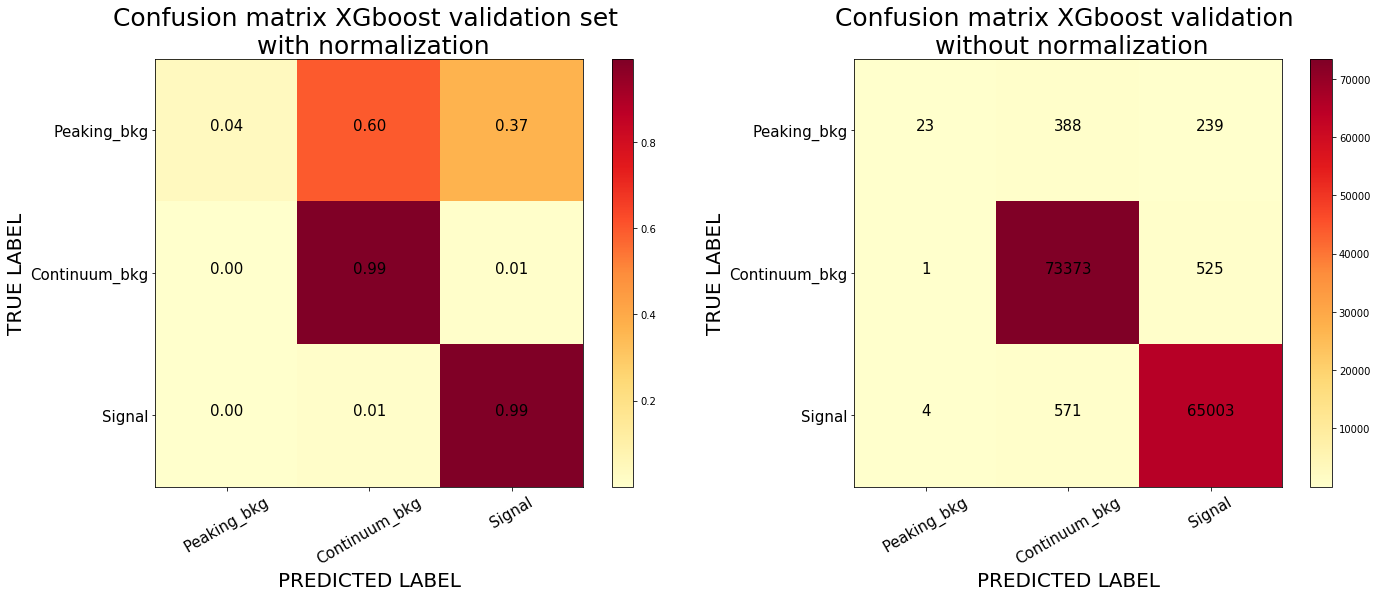

In [24]:
cnf_matrix_xg_val = confusion_matrix(Y_Validation_single_col,y_pred_val)

plot_confusion_matrix(cnf_matrix_xg_val, classes=['Peaking_bkg', 'Continuum_bkg',"Signal"],
                      title1="Confusion matrix XGboost validation set \n with normalization",
                      title2='Confusion matrix XGboost validation \n without normalization')

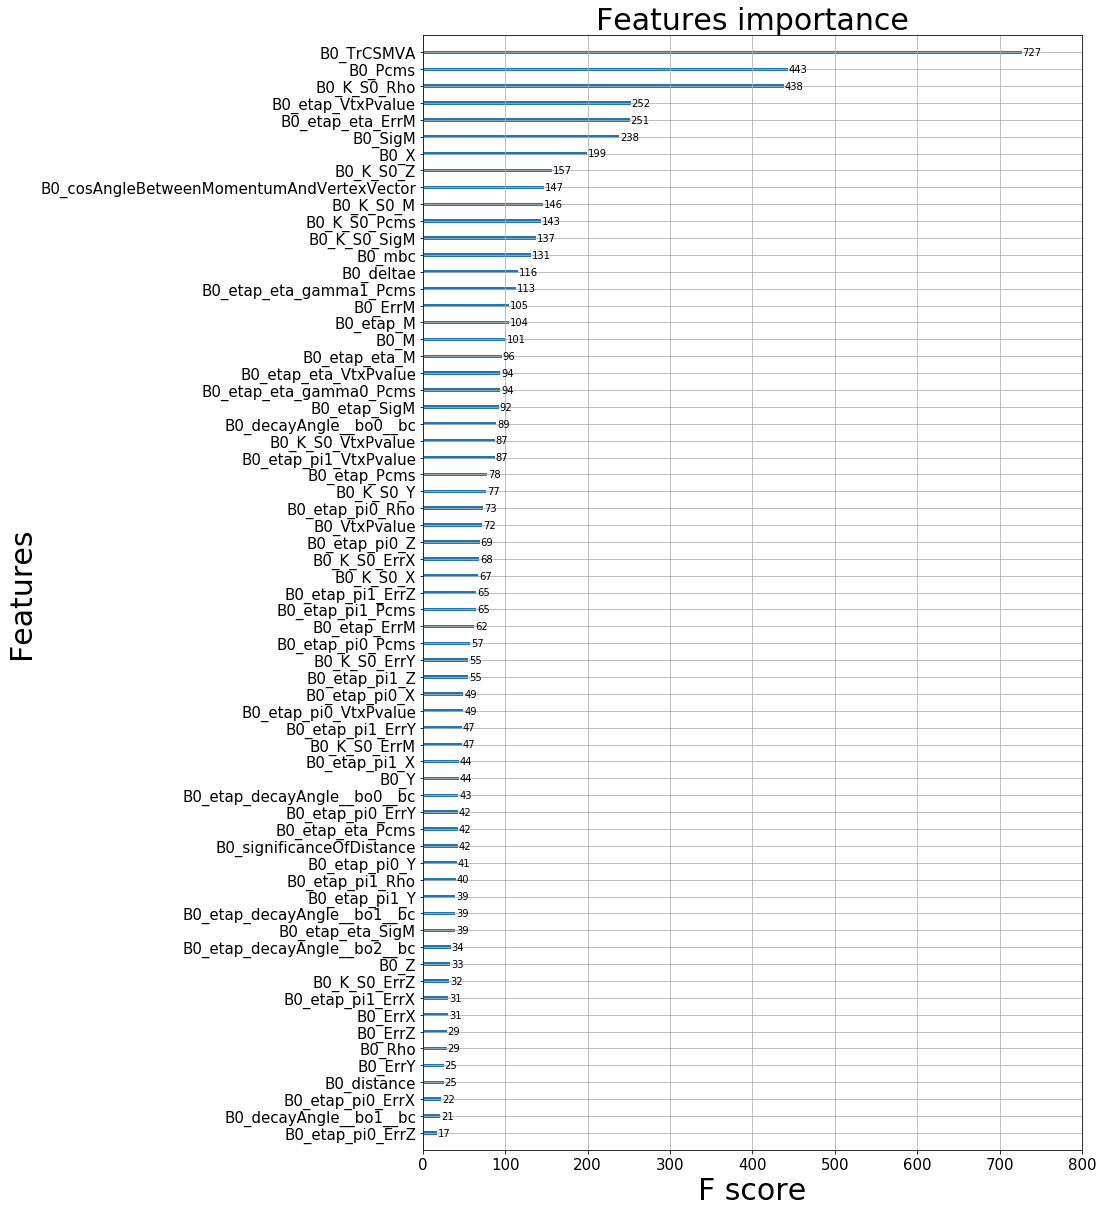

In [25]:
fig=plt.figure()
fig.set_size_inches(30.5, 20.5)
plt.tick_params(labelsize=15)
xgb.plot_importance(xgb_model, ax=plt.gca())
plt.title("Features importance",fontsize=30)
plt.ylabel("Features",fontsize=30)
plt.xlabel("F score",fontsize=30)
fig.subplots_adjust(left=0.6)  #

## 5. Deciding on the Cut Value of our Network

After deciding on the best model, we need to look for the right cut value at which we decide if an event is to be classfied as signal or background. It is common to look for the cut value that maximizes the fraction 
$ \frac{N_{S}}{\sqrt{N_{T}}} $.

To find the best cut value we are using the test subset of our training data. It corresponds to 
$ 160 \, fb^{-1} $ and thus - accounting for the reconstruction efficiency - should contain $ 113 $ signals.
As we mixed this with $ 20 \% $ of the signal files ($ 43719 $ reconstructed events) we will have to scale the signals we found by a factor of 
$ s = 0.0022 $.

Our classifier tends to output very high probabilities thus the cut value also will turn out to be very high with very little background left. As a comparison we also set a second and arbitrary cut value at $0.7$. 

In [26]:
Test_prob = Model.predict(pcTest)
np.argmax(Test_prob, axis=1)

#eps_reco = 0.137
eps_reco  = 0.162
#eps_reco  = 0.291
scaling = (3494 * eps_reco * 0.2) / (Signal.shape[0] * 0.2 + 3494 * eps_reco * 0.2)
min_cut = 0.96
max_cut = 0.999
n_steps = 100
step_size = (max_cut-min_cut)/n_steps

cut_values = []
metriks1 = []
metriks2 = []
N_Ss = []
N_Bs = []

for i in range(0, n_steps) : 
    cut_value = min_cut + i*step_size
    cut_values.append(cut_value)
    N_S = 0
    N_B = 0
    for j in range(len(Test_prob)) : 
        if Test_prob[j][2] > cut_value :           #we classify it as signal
            if Y_Test[j][2] == 1 : N_S += 1        #it actually is signal
            elif Y_Test[j][2] == 0 : N_B +=1       #it isn't signal
            else : print("Unexpected!")            #This should not happen
    
    N_S = scaling * N_S
    #N_S = 1 * N_S

    N_Ss.append(N_S)
    N_Bs.append(N_B)
    metrik1 = N_S/(math.sqrt(N_B+N_S))
    metriks1.append(metrik1)
    metrik2 = N_S/math.sqrt(N_B)
    metriks2.append(metrik2)
    
cut = cut_values[np.argmax(metriks1)]

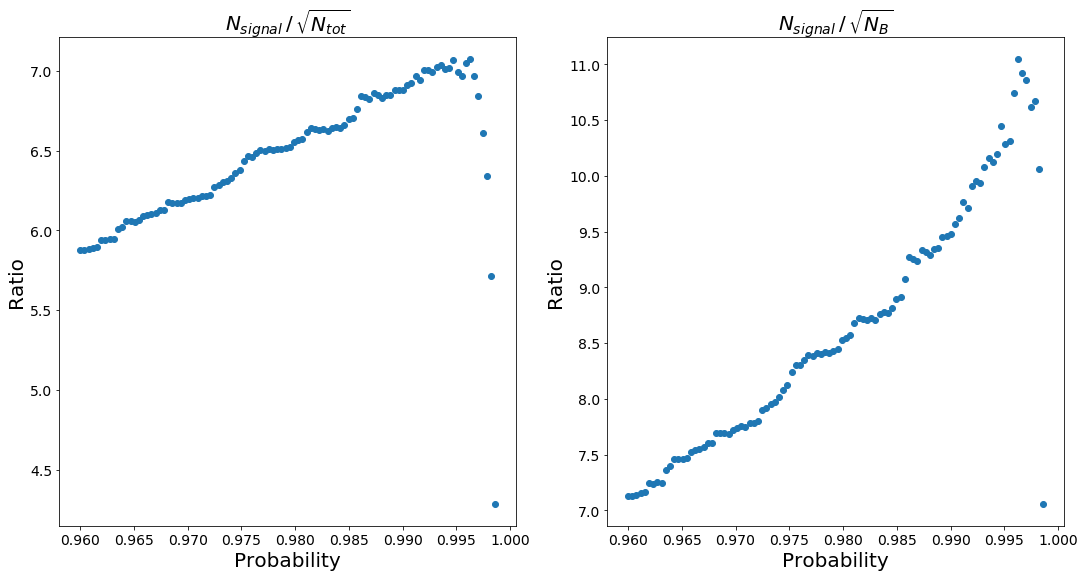

Maximum for N_signal/sqrt(N_tot) at  0.99627


In [27]:
fig, ax = plt.subplots(1,2,figsize = (18,9))
ax[0].plot(cut_values, metriks1, 'o')
ax[0].set_title(r"$N_{signal} \, / \,  \sqrt{N_{tot}}$",fontsize=20)
ax[0].set_ylabel('Ratio',fontsize=20)
ax[0].set_xlabel('Probability',fontsize=20)
ax[0].tick_params(labelsize=14)
ax[1].plot(cut_values, metriks2, 'o')
ax[1].set_title(r"$N_{signal} \, / \,  \sqrt{N_B}$",fontsize=20)
ax[1].set_ylabel('Ratio',fontsize=20)
ax[1].set_xlabel('Probability',fontsize=20)
ax[1].tick_params(labelsize=14)
plt.show()
print("Maximum for N_signal/sqrt(N_tot) at ", cut)

In [28]:
cut = cut_values[np.argmax(metriks1)]
cut1 = 0.7

N_TS, N_WS = 0,0

for j in range(len(Test_prob)) : 
        if Test_prob[j][2] > cut :           #we classify it as signal
            if Y_Test[j][2] == 1 : N_TS += 1        #it actually is signal
            elif Y_Test[j][2] == 0 : N_WS +=1       #it isn't signal
            else : print("Unexpected!")            #This should not happen
                
                
N_Sig = 0
for y in Y_Test : 
    if np.array_equal([0,0,1], y) : N_Sig +=1
        
eps = N_TS/N_Sig
print ("Efficiency with our cutvalue {}: ".format(cut), eps )

N_TS, N_WS = 0,0

for j in range(len(Test_prob)) : 
        if Test_prob[j][2] > cut1 :           #we classify it as signal
            if Y_Test[j][2] == 1 : N_TS += 1        #it actually is signal
            elif Y_Test[j][2] == 0 : N_WS +=1       #it isn't signal
            else : print("Unexpected!")            #This should not happen
                
                
N_Sig = 0
for y in Y_Test : 
    if np.array_equal([0,0,1], y) : N_Sig +=1
        
eps1 = N_TS/N_Sig
print ("Efficiency with our cutvalue {}: ".format(cut1), eps1 )

Efficiency with our cutvalue 0.99627:  0.7516697163769442
Efficiency with our cutvalue 0.7:  0.9913540713632205


## 6. The Data Challenge

We estimate the branching fraction using our model on the data challenge files

In [29]:
DC = pd.concat((read_root(f, 'B0', columns=Important) for f in DCFiles)).reset_index(drop=True)
DC = DC[Training]
pcDC = ss.transform(np.array(DC.values))
DC_prob = pd.DataFrame(Model.predict(pcDC))
DC_Signal = DC[DC_prob[2] > cut]
DC_Signal1 = DC[DC_prob[2] > cut1]

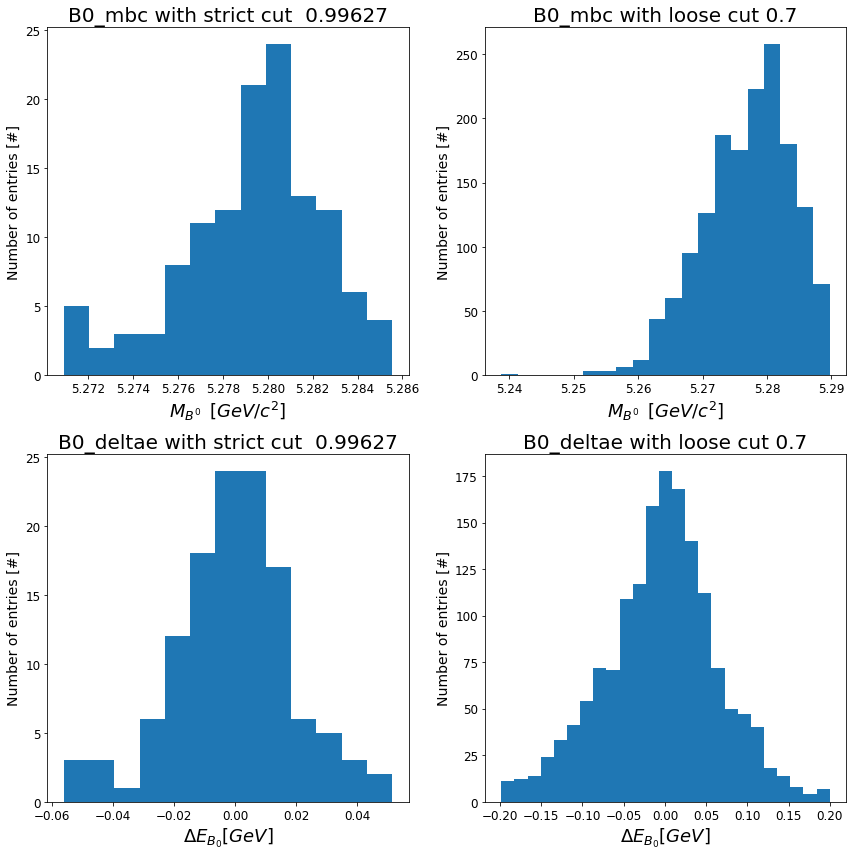

In [30]:
fig, ax = plt.subplots(2,2, figsize=(12,12))
ax[0][0].hist(DC_Signal['B0_mbc'], bins=13)
ax[0][0].set_title('B0_mbc with strict cut  '+str(cut), fontsize=20)
ax[0][0].tick_params(labelsize=12)
ax[0][0].set_ylabel(r'Number of entries [#]',fontsize=14)
ax[0][0].set_xlabel(r'$M_{B^{0}} \,\,\, [GeV/c^2]$',fontsize=18)
ax[1][0].hist(DC_Signal['B0_deltae'], bins=13)
ax[1][0].set_title('B0_deltae with strict cut  '+str(cut), fontsize=20)
ax[1][0].set_xlabel(r'$\Delta E_{B_{0}} [GeV]$',fontsize=18)
ax[1][0].tick_params(labelsize=12)
ax[1][0].set_ylabel(r'Number of entries [#]',fontsize=14)
ax[0][1].hist(DC_Signal1['B0_mbc'], bins=20)
ax[0][1].set_title('B0_mbc with loose cut '+str(round(cut1,4)), fontsize=20)
ax[0][1].tick_params(labelsize=12)
ax[0][1].set_ylabel(r'Number of entries [#]',fontsize=14)
ax[0][1].set_xlabel(r'$M_{B^{0}} \,\,\, [GeV/c^2]$',fontsize=18)
ax[1][1].hist(DC_Signal1['B0_deltae'], bins=25)
ax[1][1].set_title('B0_deltae with loose cut '+str(round(cut1,4)), fontsize=20)
ax[1][1].tick_params(labelsize=12)
ax[1][1].set_ylabel(r'Number of entries [#]',fontsize=14)
ax[1][1].set_xlabel(r'$\Delta E_{B_{0}} [GeV]$',fontsize=18)
fig.tight_layout()
fig.show()

In [31]:
from scipy.optimize import curve_fit

def fit_function(x, A , C, mu, sigma):
    return (A + C * np.exp(-1.0 * (x - mu)**2 / (2 * sigma**2)))

def flat_line(A):
    return (A)

def gaussian(x,C, mu, sigma):
    return (C * np.exp(-1.0 * (x - mu)**2 / (2 * sigma**2)))

In [32]:
nbins=13

hist, bins = np.histogram(DC_Signal['B0_mbc'], bins=nbins)
centers = (bins[:-1] + bins[1:]) / 2
popt3, pcov3 = curve_fit(fit_function,xdata=centers,ydata=hist,p0=[3,1, 5.28, 0.005])
A , C, mu, sigma = popt3
dA , dC, dmu, dsigma = [np.sqrt(pcov3[j,j]) for j in range(popt3.size)]
print("Parameters with strict cut", popt3)

Parameters with strict cut [ 3.62652773e+00  1.80114163e+01  5.28002007e+00 -1.91944638e-03]


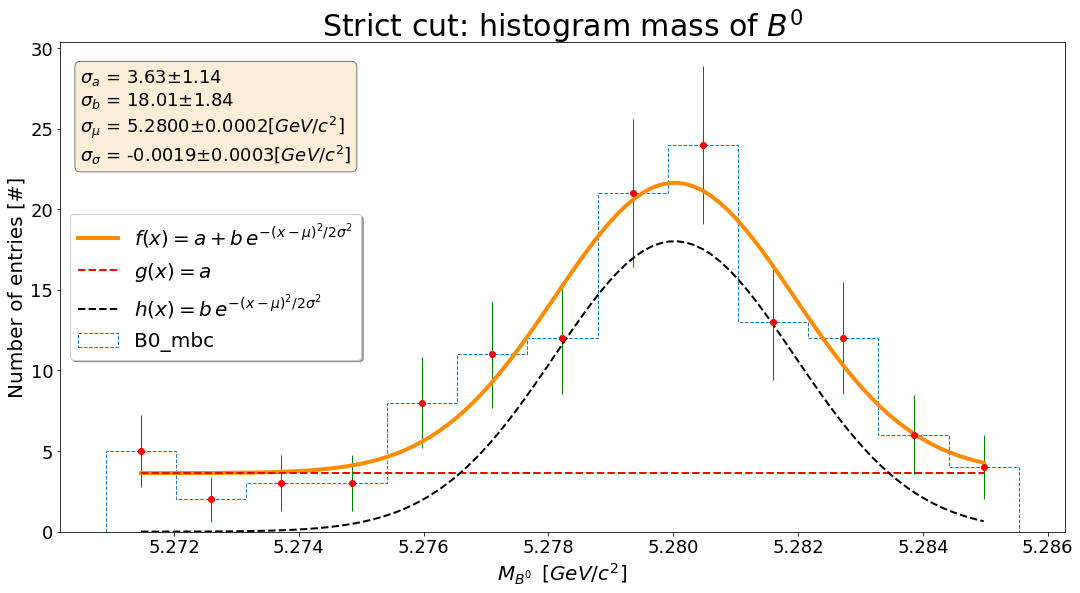

In [33]:
x = np.linspace(centers.min(), centers.max(), 100)
flat_line(*popt3[:1])
fig, ax = plt.subplots(1,1)

ax.hist(DC_Signal['B0_mbc'], bins=nbins,linestyle='--',histtype='step')
ax.plot(x, fit_function(x, *popt3), color='darkorange', linewidth=4, label=r'$f(x) = a+b\,e^{-(x-\mu)^2/2\sigma^2}$')
ax.plot(x,flat_line(*popt3[:1])*np.ones(x.shape[0]), color='red', linewidth=2, label=r'$g(x) = a$',linestyle='--')
ax.errorbar(centers, hist, ecolor="green",elinewidth=1,fmt="ro",yerr=np.sqrt(hist))
ax.plot(x, gaussian(x, *popt3[1:]), color='black', linewidth=2, label=r'$h(x) = b\,e^{-(x-\mu)^2/2\sigma^2}$',linestyle='--')
ax.set_xlabel('$M_{B^{0}} \,\,\, [GeV/c^2]$',fontsize=20)
ax.set_ylabel(r'Number of entries [#]',fontsize=20)
ax.set_title('Strict cut: histogram mass of $B^{0}$',fontsize=30)
plt.tick_params(labelsize=18)
textstr = '\n'.join((
    '$\sigma_a$ = {0:0.2f}$\pm${1:0.2f}'
         .format(A, dA),
    '$\sigma_b$ = {0:0.2f}$\pm${1:0.2f}'
         .format(C, dC),
    '$\sigma_\mu$ = {0:0.4f}$\pm${1:0.4f}$[GeV/c^2]$'
         .format(mu, dmu),
     '$\sigma_\sigma$ = {0:0.4f}$\pm${1:0.4f}$[GeV/c^2]$'
         .format(sigma, dsigma)))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.02, 0.95, textstr, transform=ax.transAxes, fontsize=18,
        verticalalignment='top', bbox=props)
legend = ax.legend(loc="center left", shadow=True, fontsize=20)

fig.set_size_inches(18, 9)
plt.show()

In [34]:
import scipy.integrate as integrate

idx = np.argwhere(np.diff(np.sign(flat_line(*popt3[:1])*np.ones(x.shape[0]) - gaussian(x, *popt3[1:])))).flatten()
result =integrate.quad(lambda x: gaussian(x,C=popt3[1], mu=popt3[2], sigma=popt3[3]),x[idx][0],x[idx][1])
bin_width = bins[1] - bins[0]
N_Sig = (result[0]/bin_width) / ( eps_reco * eps)
integral=result[0]/bin_width
integral_error=math.sqrt(integral)


BF = N_Sig / (1. * 10**18 * 1.1 * 10**(-9))
BF_error=integral_error/ ( eps_reco * eps*1. * 10**18 * 1.1 * 10**(-9))
BF_alt = N_Sig / (0.32 * 10**18 * 1.1 * 10**(-9))
BF_error_alt=integral_error/ ( eps_reco * eps*0.32 * 10**18 * 1.1 * 10**(-9))

print("The integral under the black curve is : ", result[0])
print("Number of found Signal: \t\t", result[0]/bin_width)
print("Error on number of Signal: \t\t", integral_error)
print("Existing Signal: \t\t\t", N_Sig)
print ("Branching fraction: \t\t\t", BF)
print("Error on Branching fraction: \t\t", BF_error)
print ("Adjusted branching fraction: \t\t", BF_alt)
print("Error on Adjusted Branching fraction: \t", BF_error_alt)

The integral under the black curve is :  0.0800809986564388
Number of found Signal: 		 71.13173506749172
Error on number of Signal: 		 8.433963188649315
Existing Signal: 			 584.1459018511827
Branching fraction: 			 5.310417289556205e-07
Error on Branching fraction: 		 6.296467237019871e-08
Adjusted branching fraction: 		 1.6595054029863145e-06
Error on Adjusted Branching fraction: 	 1.96764601156871e-07


### Calculating the Branching fraction

We found $71 \pm 8$ signals in the data challenge. Taking into account the efficiency $ \varepsilon = 75 \% $ and the reconstruction efficiency $ \varepsilon = 16.2 \% $ we conclude that we have $ N_{sig} = 584 \pm  69$ signal events in the data challenge. 

$$
N_{sig} = \mathcal{L} \times \sigma_{\Upsilon(4S)} \times \mathcal{BF}
$$

$$ 
\Rightarrow \mathcal{BF} = \frac{N_{sig}}{\mathcal{L} \times \sigma{\Upsilon_{(4S)}}} = \frac{584}{1 \, ab^{-1} \cdot 1.1 \, nb} = \left( 5.3 \pm 0.6 \right) \cdot 10^{-7}
$$

We have reason to believe, that our data challenge files do not correspond to $ 1 \, ab^{-1} $ : 

- The background files correspond to $ 0.8 \, ab^{-1} $ and contain $ 248 496 $ events. 
- Given the same reconstruction efficiency we would expect a simulation with an integrated Luminosity of $ 1 \, ab^{-1} $ to contain about $ 310 000 $ events. 
- The DC files contain in total $ 98 747 $ events
- We therefore estimate the integrated luminosity of our DC files to be or not to be around $ 0.32 \, ab^{-1} $

With this correction we recalculate the branching fraction and get a result of $ \mathcal{BF} = \left( 1.5 \pm 0.2 \right) \cdot 10^{-6}$

# Study of cut value incidence on BF
In order to estimate systematic uncertainties on $ \mathcal{BF}$ related to the cut value choice and to the background modeling we tried to estimate the $ \mathcal{BF}$ using different cut values (that lead to different background fractions classified as Signal).

[0.97, 0.972, 0.974, 0.975, 0.976, 0.978, 0.98, 0.9825, 0.985, 0.986, 0.988, 0.99, 0.99627]
Cut Value: 0.97
Selected events:  415


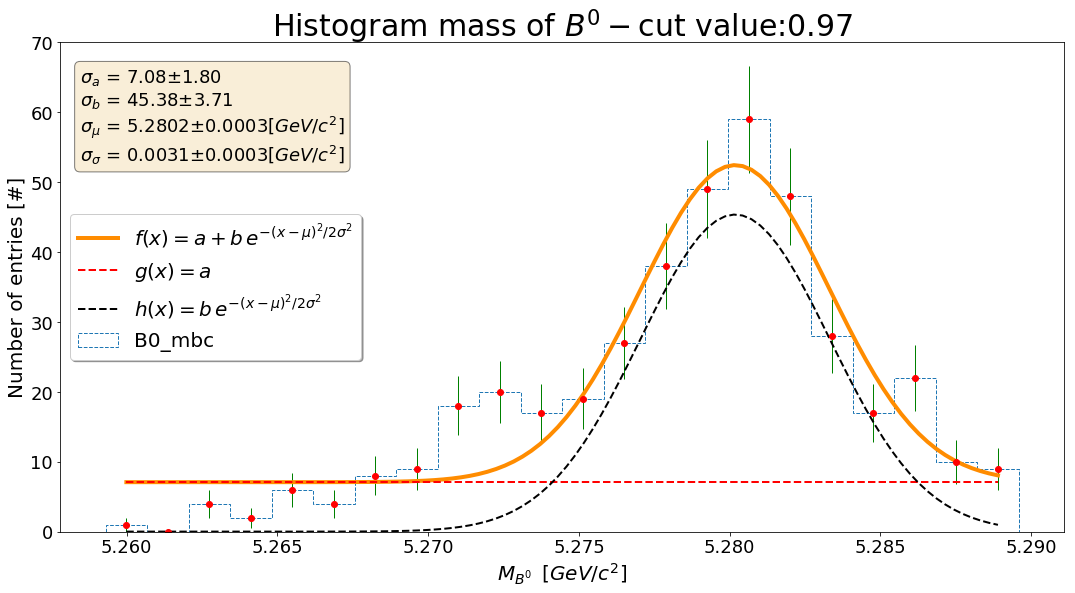

(2,)
The integral under the black curve is :  0.3369923669293019
Number of Signal:  244.7953641463524
Error on number of Signal:  15.64593762439159



Cut Value: 0.972
Selected events:  404


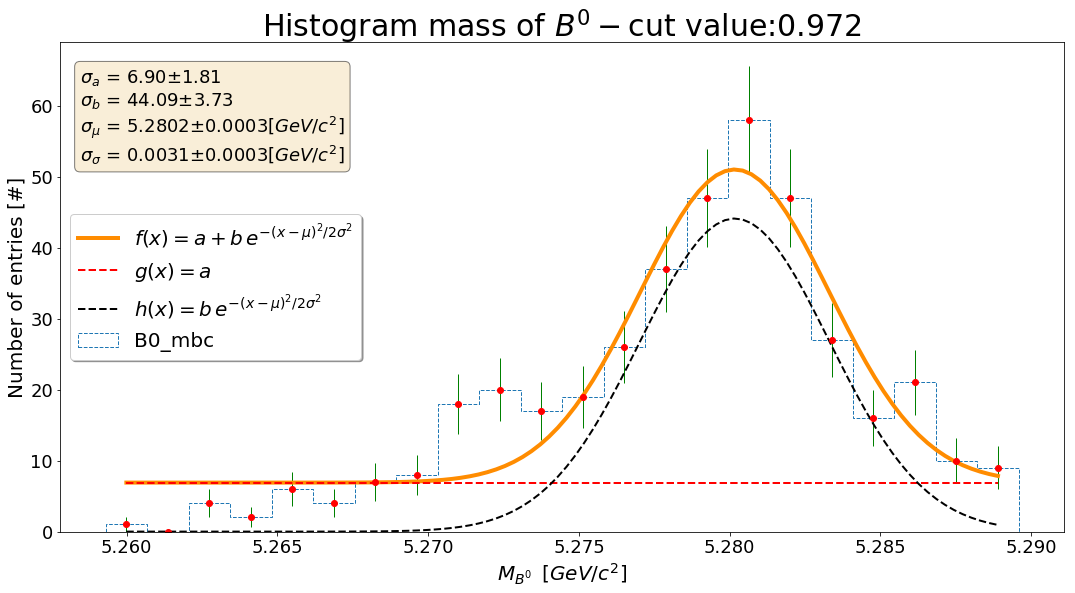

(2,)
The integral under the black curve is :  0.3276463295897534
Number of Signal:  238.0062886705267
Error on number of Signal:  15.427452436177747



Cut Value: 0.974
Selected events:  385


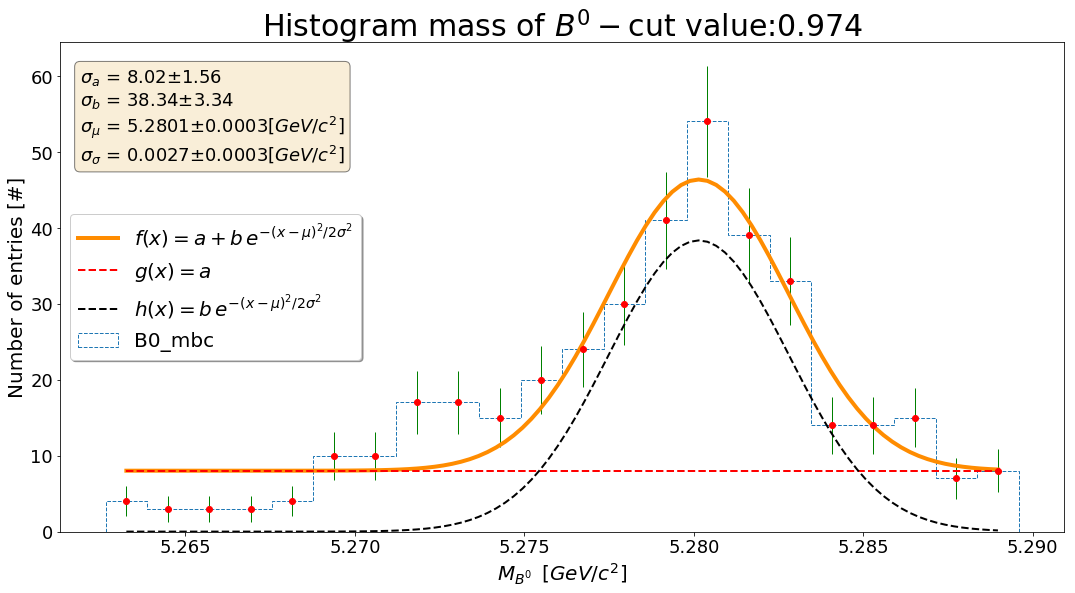

(2,)
The integral under the black curve is :  0.23733296543332782
Number of Signal:  193.81748564035604
Error on number of Signal:  13.921834851784302



Cut Value: 0.975
Selected events:  379


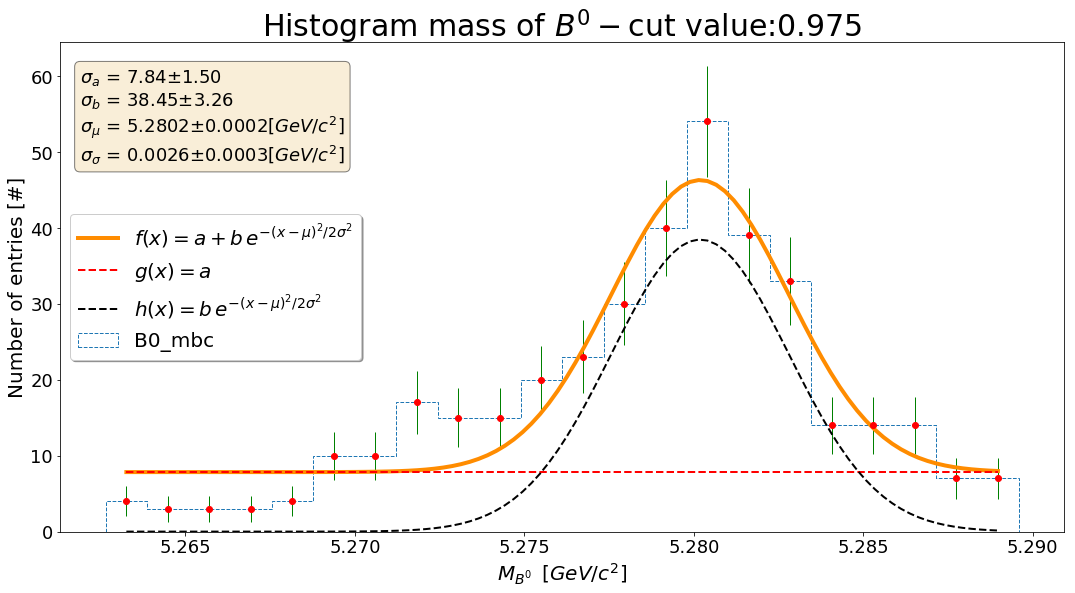

(2,)
The integral under the black curve is :  0.23406192739828935
Number of Signal:  191.14619905263913
Error on number of Signal:  13.825563245403028



Cut Value: 0.976
Selected events:  368


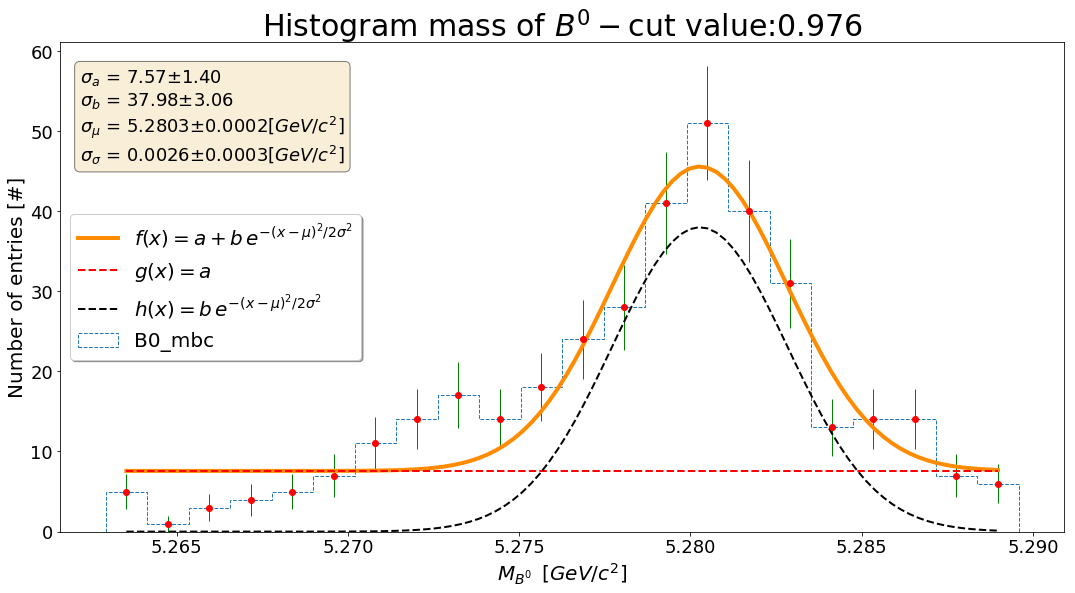

(2,)
The integral under the black curve is :  0.22671740122302766
Number of Signal:  187.11564400223335
Error on number of Signal:  13.679022041148752



Cut Value: 0.978
Selected events:  354


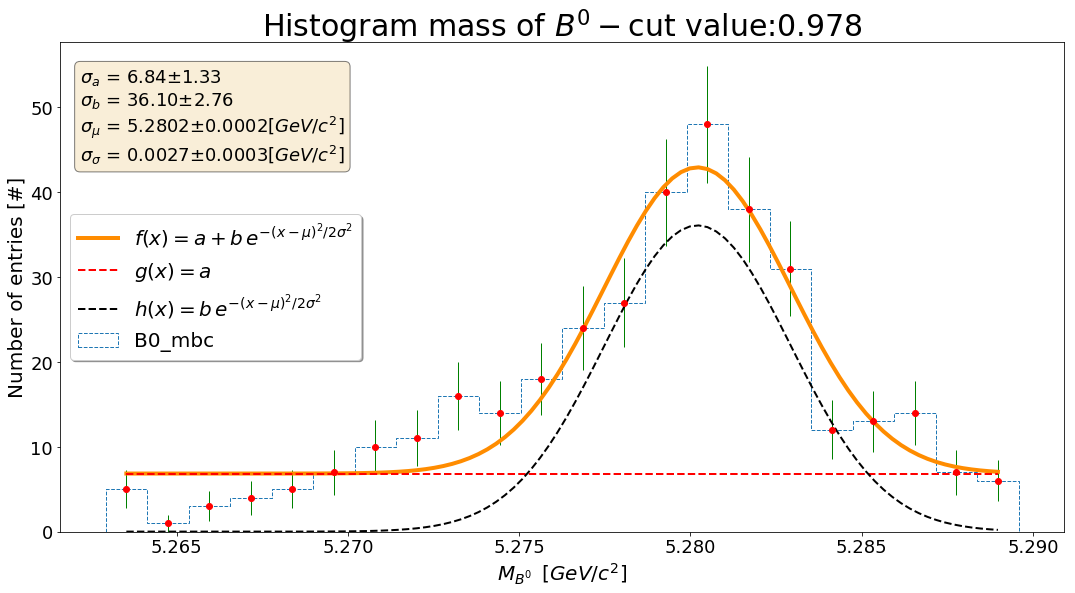

(2,)
The integral under the black curve is :  0.23027695633295328
Number of Signal:  190.05343546932926
Error on number of Signal:  13.78598692402286



Cut Value: 0.98
Selected events:  343


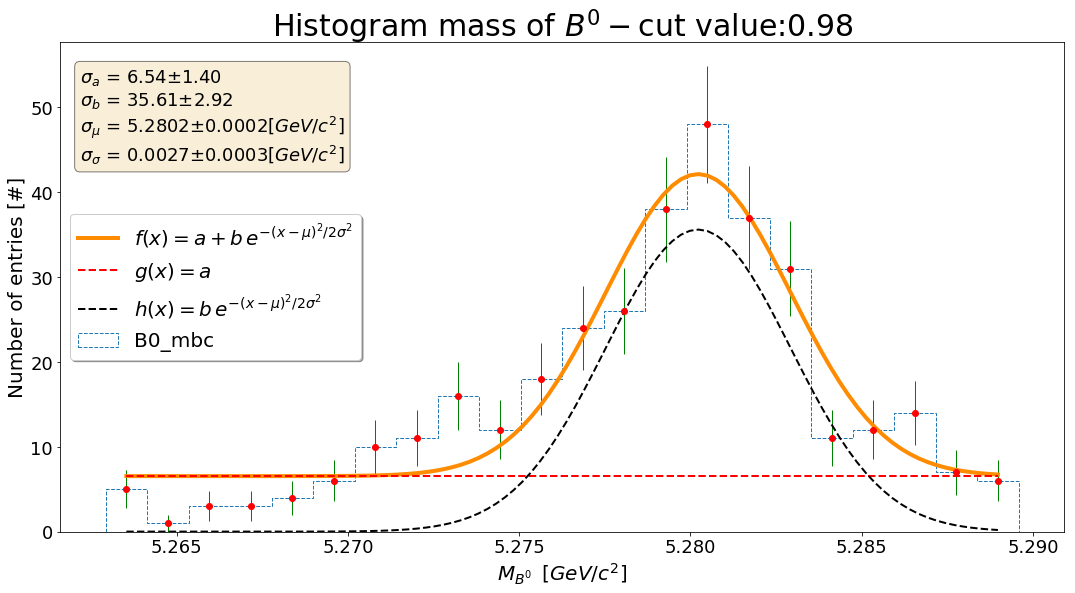

(2,)
The integral under the black curve is :  0.2258915067768178
Number of Signal:  186.43401228650808
Error on number of Signal:  13.654084088158681



Cut Value: 0.9825
Selected events:  309


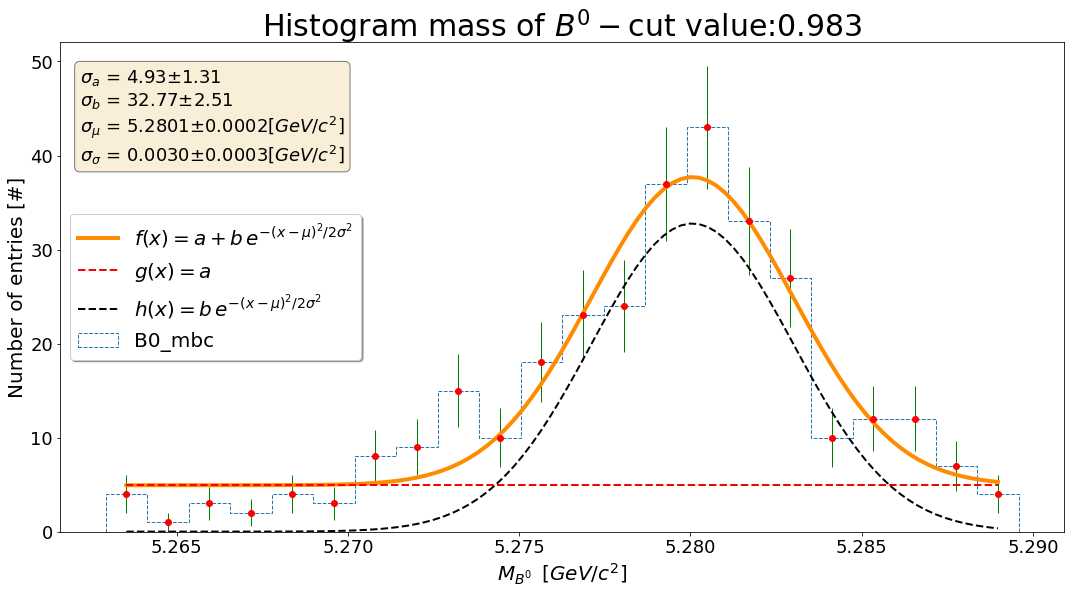

(2,)
The integral under the black curve is :  0.2306262208594444
Number of Signal:  190.34169237616118
Error on number of Signal:  13.796437669781326



Cut Value: 0.985
Selected events:  279


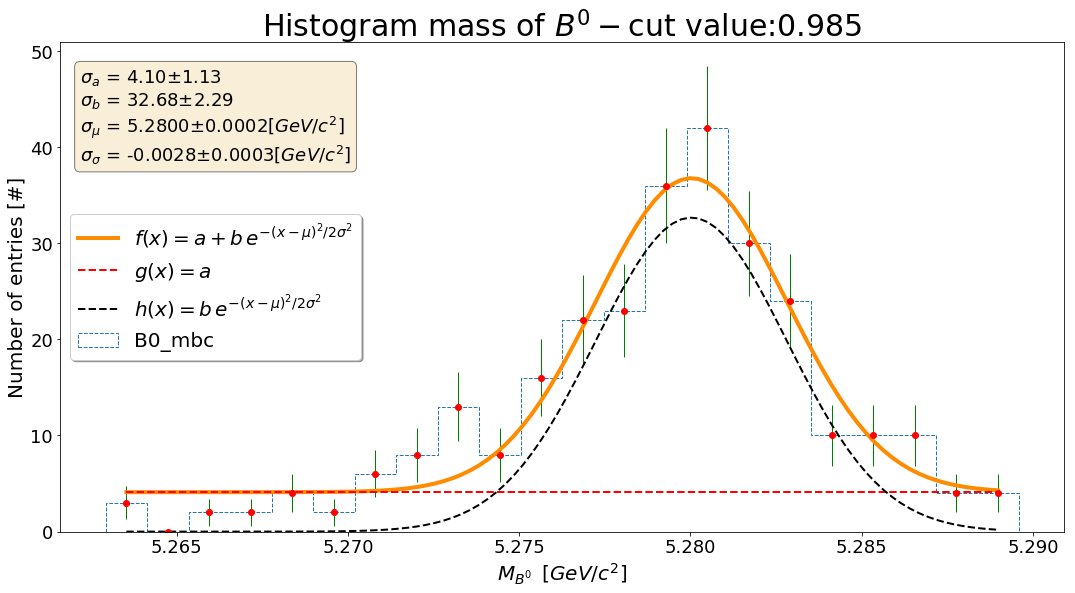

(2,)
The integral under the black curve is :  0.21893748657631945
Number of Signal:  180.69468234887898
Error on number of Signal:  13.442272216737726



Cut Value: 0.986
Selected events:  268


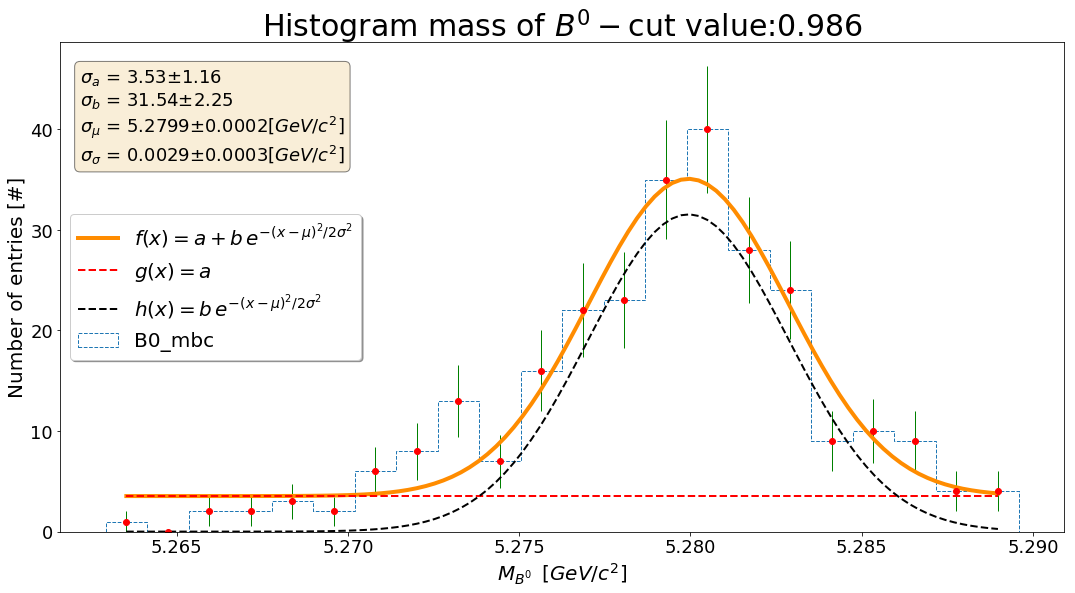

(2,)
The integral under the black curve is :  0.22178154227124366
Number of Signal:  183.04195393043022
Error on number of Signal:  13.529299831492768



Cut Value: 0.988
Selected events:  246


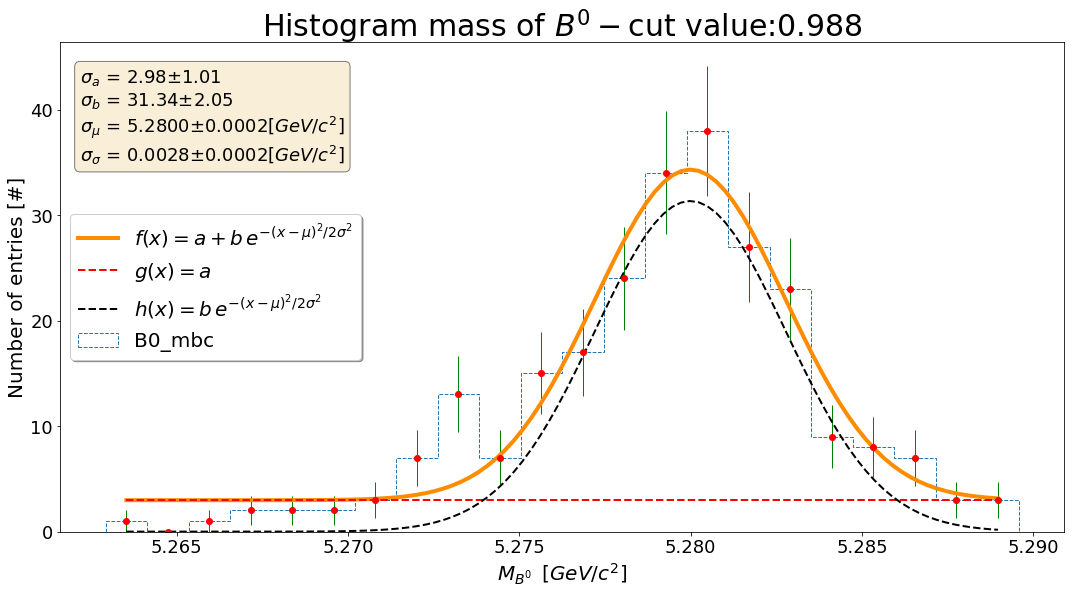

(2,)
The integral under the black curve is :  0.21200492598326567
Number of Signal:  175.0419506045896
Error on number of Signal:  13.230342044126811



Cut Value: 0.99
Selected events:  223


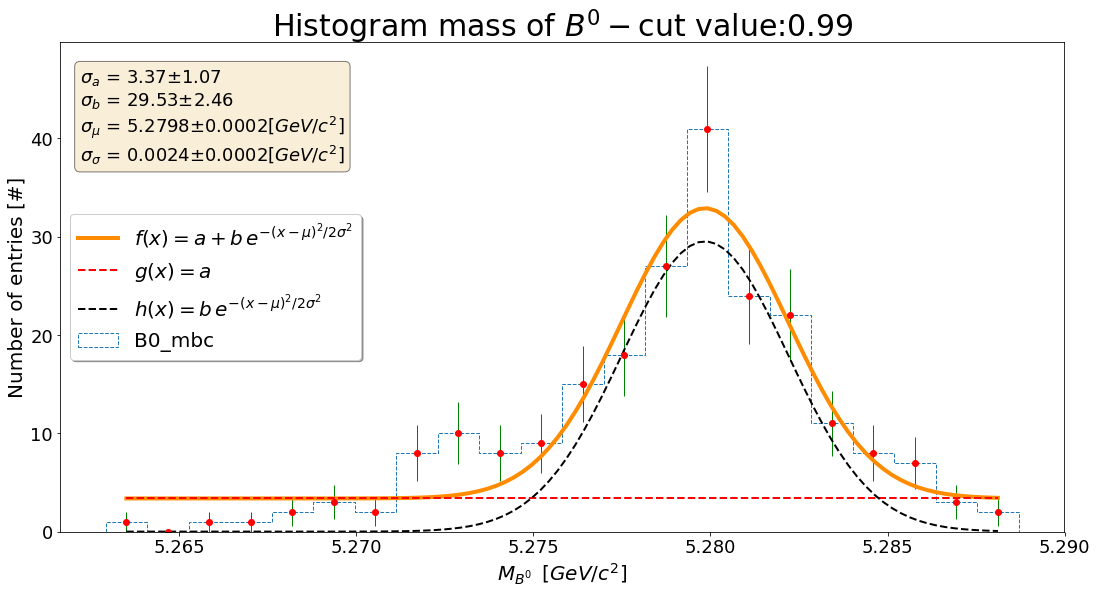

(2,)
The integral under the black curve is :  0.168155058922137
Number of Signal:  143.52735780572954
Error on number of Signal:  11.980290389040222



Cut Value: 0.99627
Selected events:  124


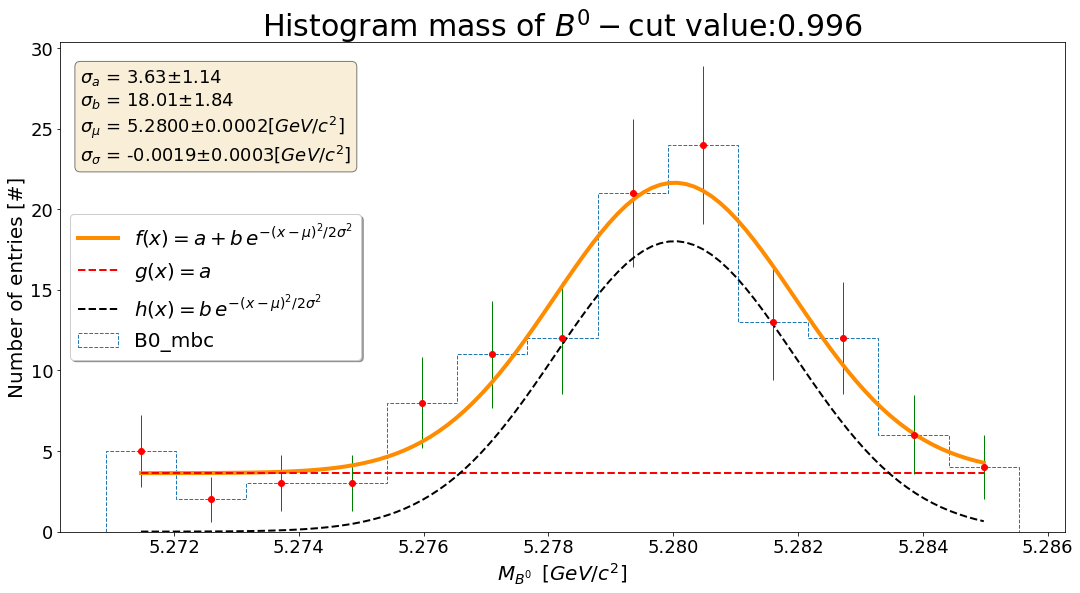

(2,)
The integral under the black curve is :  0.0800809986564388
Number of Signal:  71.13173506749172
Error on number of Signal:  8.433963188649315





In [35]:
#cut_values_syst=[cut,0.95, 0.96, 0.97, 0.98]
cut_values_syst=[0.97,0.972, 0.974,0.975,0.976,0.978,0.980, 0.9825, 0.985, 0.986,0.988,0.990, cut]
#bins_list=[22,29,29,22,22]
bins_list=[22,22,22,22,22,22,22,22,22,22,22,22, 13]
print(cut_values_syst)
BF_syst=[]
stat_err_BF=[]

for i in range(len(cut_values_syst)):
    print("Cut Value:", cut_values_syst[i])
    DC_Signal = DC[DC_prob[2] > cut_values_syst[i]]
    print("Selected events: ", DC_Signal.shape[0])
    #Fit
    nbins=bins_list[i]
    hist, bins = np.histogram(DC_Signal['B0_mbc'], bins=nbins)
    centers = (bins[:-1] + bins[1:]) / 2
    popt3, pcov3 = curve_fit(fit_function,xdata=centers,ydata=hist,p0=[3,1, 5.28, 0.005])
    A , C, mu, sigma = popt3
    dA , dC, dmu, dsigma = [np.sqrt(pcov3[j,j]) for j in range(popt3.size)]
    
    string_title="cut value:" +str(round(cut_values_syst[i],3))
    x = np.linspace(centers.min(), centers.max(), 100)
    flat_line(*popt3[:1])
    #Plot
    fig, ax1 = plt.subplots()
    ax1.hist(DC_Signal['B0_mbc'], bins=nbins,linestyle='--',histtype='step')
    ax1.plot(x, fit_function(x, *popt3), color='darkorange', linewidth=4, label=r'$f(x) = a+b\,e^{-(x-\mu)^2/2\sigma^2}$')
    ax1.plot(x,flat_line(*popt3[:1])*np.ones(x.shape[0]), color='red', linewidth=2, label=r'$g(x) = a$',linestyle='--')
    ax1.errorbar(centers, hist, ecolor="green",elinewidth=1,fmt="ro",yerr=np.sqrt(hist))
    ax1.plot(x, gaussian(x, *popt3[1:]), color='black', linewidth=2, label=r'$h(x) = b\,e^{-(x-\mu)^2/2\sigma^2}$',linestyle='--')
    ax1.set_xlabel('$M_{B^{0}} \,\,\, [GeV/c^2]$',fontsize=20)
    ax1.set_ylabel(r'Number of entries [#]',fontsize=20)
    ax1.set_title('Histogram mass of $B^{0} - $'+string_title,fontsize=30)
    fig.set_size_inches(18, 9)
    plt.tick_params(labelsize=18)
    textstr = '\n'.join((
        '$\sigma_a$ = {0:0.2f}$\pm${1:0.2f}'
             .format(A, dA),
        '$\sigma_b$ = {0:0.2f}$\pm${1:0.2f}'
             .format(C, dC),
        '$\sigma_\mu$ = {0:0.4f}$\pm${1:0.4f}$[GeV/c^2]$'
             .format(mu, dmu),
         '$\sigma_\sigma$ = {0:0.4f}$\pm${1:0.4f}$[GeV/c^2]$'
             .format(sigma, dsigma)))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax1.text(0.02, 0.95, textstr, transform=ax1.transAxes, fontsize=18,
            verticalalignment='top', bbox=props)
    legend = ax1.legend(loc="center left", shadow=True, fontsize=20)
    plt.show()
    #Compute Integral
    idx = np.argwhere(np.diff(np.sign(flat_line(*popt3[:1])*np.ones(x.shape[0]) - gaussian(x, *popt3[1:])))).flatten()
    print(idx.shape)
    result =integrate.quad(lambda x: gaussian(x,C=popt3[1], mu=popt3[2], sigma=popt3[3]),x[idx][0],x[idx][1])
    print("The integral under the black curve is : ", result[0])
    
    #Compute number of signal
    bin_width = bins[1] - bins[0]
    print("Number of Signal: ", result[0]/bin_width)
    integral=result[0]/bin_width
    integral_error=math.sqrt(integral)
    print("Error on number of Signal: ", integral_error)
    N_Sig = (result[0]/bin_width) / ( eps_reco * eps)
    
    #Compute BR
    N_Sig = integral / ( eps_reco * eps)
    BF_syst.append(N_Sig / (1. * 10**18 * 1.1 * 10**(-9)))
    stat_err_BF.append(integral_error/ ( eps_reco * eps*1. * 10**18 * 1.1 * 10**(-9)))
    print(2*"\n")
    
    
    
    

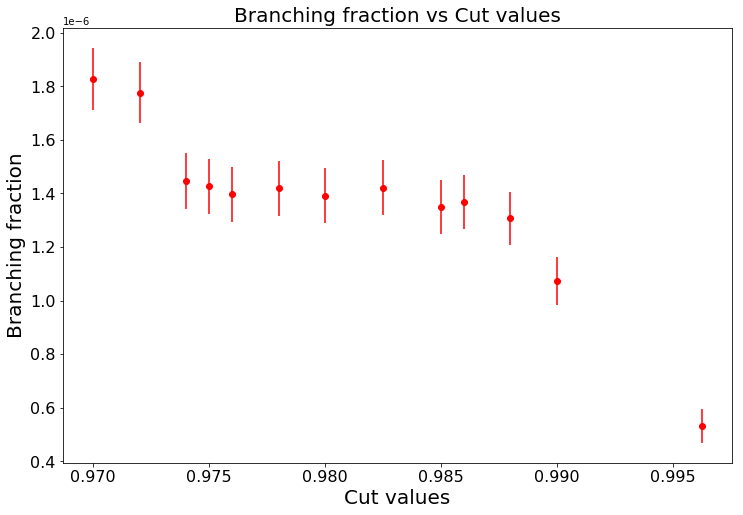

In [36]:
fig, ax = plt.subplots(1,1,figsize = (12,8))
ax.errorbar(cut_values_syst, BF_syst, yerr=stat_err_BF,xerr=None, fmt='ro')
ax.set_xlabel("Cut values", fontsize=20)
ax.set_ylabel("Branching fraction", fontsize=20)
ax.set_title("Branching fraction vs Cut values", fontsize=20)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.tick_params(labelsize=16)
plt.show()

The estimated $ \mathcal{BF}$ changes as we change the cut value, but there is a region, (0.975,0.985), in which the $ \mathcal{BF}$ seems to be stable. This is due to the fact that the classifier discards almost all the "low mass" background making it difficult to find the correct function to fit the background and subtruct it from the signal peak. Due to this fact the linear approximation for the background is not always valid.
We did this study only for cut values close to the selected one because for lower cut values we don't know how to model the background as it is almost exclusively in the signal region. 

In [37]:
print("Branching fraction with cut value {}:\t\t\t BF = {} ".format(cut_values_syst[6], BF_syst[6]))
print("Error on Branching fraction with cut value {}:\t BF_err = {} ".format(cut_values_syst[6], stat_err_BF[6]))

Branching fraction with cut value 0.98:			 BF = 1.3918434595588418e-06 
Error on Branching fraction with cut value 0.98:	 BF_err = 1.0193605448540478e-07 


## Conclusions
### Problems
1. The classifier should be improved for classifying peaking background
1. The $\mathcal{BF}$ dependence on the cut value has to be fully understood and the cut value has to be choosen accordingly
1. If the cut value is to be choosen lower we need a more elaborate model to fit the background or instead have to look at other variables

### Possible Solutions
1. Retrain the neural network without using the continuum suppression variable
1. If possible train the network with more peaking background
1. Understand the apparent discrepancy between the high luminosity of DC files and the relatively low amount of events

## Backup Plots



Events with strict cut:  0
Events with loose cut:  2486


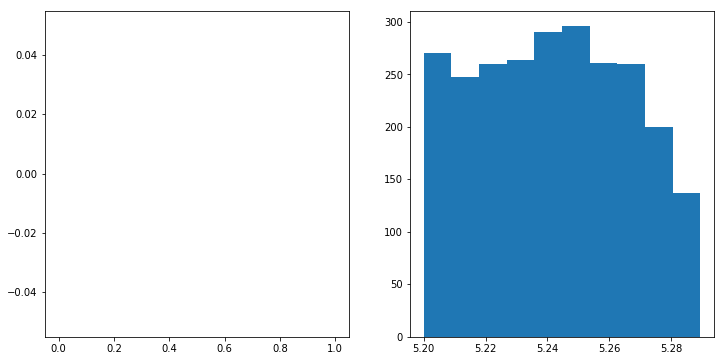

In [38]:
C_prob = pd.DataFrame(Model.predict(ss.transform(Continuum_bkg.drop(['Type'], axis=1).values)))
C_Signal = Continuum_bkg[C_prob[2] > cut]
C_Signal1 = Continuum_bkg[C_prob[2] > cut1]

fig, ax = plt.subplots(1,2, figsize=(12,6))

ax[0].hist(C_Signal['B0_mbc'])
ax[1].hist(C_Signal1['B0_mbc'])

fig.show()

print("Events with strict cut: ", C_Signal.shape[0])
print("Events with loose cut: ", C_Signal1.shape[0])

Events with strict cut:  141
Events with loose cut:  389


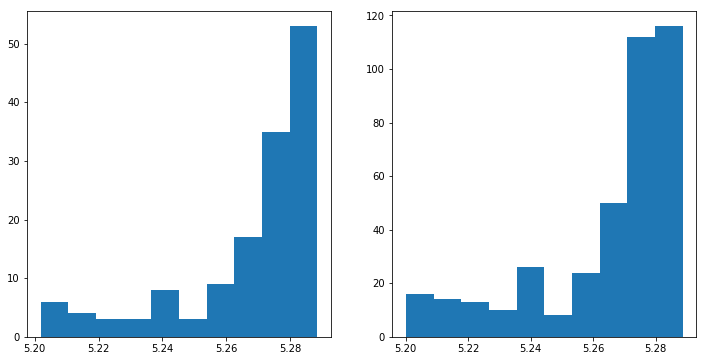

In [39]:
P_prob = pd.DataFrame(Model.predict(ss.transform(Peaking_bkg.drop(['Type'], axis=1).values)))
P_Signal = Peaking_bkg[P_prob[2] > cut]
P_Signal1 = Peaking_bkg[P_prob[2] > cut1]

fig, ax = plt.subplots(1,2, figsize=(12,6))

ax[0].hist(P_Signal['B0_mbc'])
ax[1].hist(P_Signal1['B0_mbc'])

fig.show()

print("Events with strict cut: ", P_Signal.shape[0])
print("Events with loose cut: ", P_Signal1.shape[0])

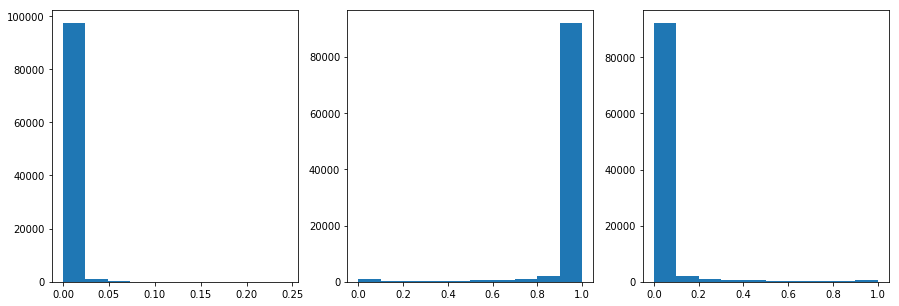

In [40]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].hist(np.array(DC_prob[0]))
ax[1].hist(np.array(DC_prob[1]))
ax[2].hist(np.array(DC_prob[2]))
fig.show()